## 01 라이브러리 다운로드

In [2]:
#필요 라이브러리 다운
import pandas as pd
pd.options.display.float_format = '{:.7f}'.format
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

#모델 관련
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import timeit

# 한글깨짐 처리
from matplotlib import rc
plt.rc('font', family='Malgun Gothic')
sns.set(font='Malgun Gothic', 
        rc={"axes.unicode_minus":False},
        style='whitegrid',
        font_scale=2)
%config InlineBackend.figure_format = 'retina'

# 마이너스 폰트 깨짐 처리
mpl.rcParams['axes.unicode_minus'] = False

#오류 무시
import warnings
warnings.filterwarnings('ignore')

## 02 데이터셋 다운로드 및 확인

### 02-1 데이터셋 다운로드

In [4]:
train=pd.read_csv('C:/data/pubg/train_V2.csv')
test=pd.read_csv('C:/data/pubg/test_V2.csv')

### 02-2 메모리 축소

In [5]:
## 데이터 크기 확인 함수
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

## 타입별 평균 크기 확인 함수
def type_memory(data) :
    for dtype in ['float','int','object']:
        selected_dtype = data.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

## 이산형 데이터 사이즈 축소 함소
def int_memory_reduce(data) :
    data_int = data.select_dtypes(include=['int'])
    converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')
    print(f"Before : {mem_usage(data_int)} -> After : {mem_usage(converted_int)}")
    data[converted_int.columns] = converted_int
    return data

## 연속형 데이터 사이즈 축소 함소
def float_memory_reduce(data) :
    data_float = data.select_dtypes(include=['float'])
    converted_float = data_float.apply(pd.to_numeric,downcast='float')
    print(f"Before : {mem_usage(data_float)} -> After : {mem_usage(converted_float)}")
    data[converted_float.columns] = converted_float
    return data

## 문자형 데이터 사이즈 축소 함소
def object_memory_reduce(data) :
    gl_obj = data.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    print(f"Before : {mem_usage(gl_obj)} -> After : {mem_usage(converted_obj)}")
    data[converted_obj.columns] = converted_obj
    return data

In [6]:
int_memory_reduce(train)
float_memory_reduce(train)
object_memory_reduce(train)
int_memory_reduce(test)
float_memory_reduce(test)
object_memory_reduce(test)

Before : 0.00 MB -> After : 0.00 MB
Before : 203.57 MB -> After : 101.78 MB
Before : 1175.91 MB -> After : 561.01 MB
Before : 0.00 MB -> After : 0.00 MB
Before : 73.78 MB -> After : 36.89 MB
Before : 511.37 MB -> After : 245.90 MB


Id         groupId         matchId  assists  boosts  \
0        9329eb41e215eb  676b23c24e70d6  45b576ab7daa7f        0       0   
1        639bd0dcd7bda8  430933124148dd  42a9a0b906c928        0       4   
2        63d5c8ef8dfe91  0b45f5db20ba99  87e7e4477a048e        1       0   
3        cf5b81422591d1  b7497dbdc77f4a  1b9a94f1af67f1        0       0   
4        ee6a295187ba21  6604ce20a1d230  40754a93016066        0       4   
...                 ...             ...             ...      ...     ...   
1934169  a316c3a13887d5  80e82180c90951  f276da5fd73536        1       2   
1934170  5312146b27d875  147264a127c56e  fb77cbfe094a6b        0       0   
1934171  fc8818b5b32ad3  7bbb4779ebedd5  efb74d5f6e9779        0       0   
1934172  a0f91e35f8458f  149a506a64c2b1  3a2cf335bc302f        1       2   
1934173  3696fc9f3a42b2  c770d7feaf020f  9d4e2b6d506fd0        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  rankPoints  \
0         51.4599991      0              0      0         73  ...        1500   
1        179.1000061      0              0      2         11  ...        1503   
2         23.3999996      0              0      4         49  ...        1565   
3         65.5199966      0              0      0         54  ...        1465   
4        330.2000122      1              2      1          7  ...        1480   
...              ...    ...            ...    ...        ...  ...         ...   
1934169  381.0000000      3              0      7          4  ...          -1   
1934170    0.0000000      0              0      0         64  ...          -1   
1934171   91.9599991      0              0      3         24  ...        1482   
1934172  138.6000061      0              0     12         25  ...        1456   
1934173   19.7999992      0              0      0         86  ...          -1   

         revives  rideDistance  roadKills  swimDistance teamKills  \
0              0     0.0000000          0     0.0000000         0   
1              2  4669.0000000          0     0.0000000         0   
2              0     0.0000000          0     0.0000000         0   
3              0     0.0000000          0     0.0000000         0   
4              1     0.0000000          0     0.0000000         0   
...          ...           ...        ...           ...       ...   
1934169        1     0.0000000          0     0.0000000         0   
1934170        0     0.0000000          0     0.0000000         0   
1934171        0     0.0000000          0     7.7979999         1   
1934172        1     0.0000000          0     0.0000000         0   
1934173        0     0.0000000          0     0.0000000         0   

         vehicleDestroys  walkDistance  weaponsAcquired  winPoints  
0                      0   588.0000000                1          0  
1                      0  2017.0000000                6          0  
2                      0   787.7999878                4          0  
3                      0  1812.0000000                3          0  
4                      0  2963.0000000                4          0  
...                  ...           ...              ...        ...  
1934169                0  1799.0000000                5       1526  
1934170                0  1195.0000000                3       1496  
1934171                0  3327.0000000                3          0  
1934172                0  1893.0000000                4          0  
1934173                0    68.8899994                0       1551  

[1934174 rows x 28 columns]

### 02-3 feature와 기술통계량 확인 및 설명

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               object  
 1   groupId          category
 2   matchId          category
 3   assists          int64   
 4   boosts           int64   
 5   damageDealt      float32 
 6   DBNOs            int64   
 7   headshotKills    int64   
 8   heals            int64   
 9   killPlace        int64   
 10  killPoints       int64   
 11  kills            int64   
 12  killStreaks      int64   
 13  longestKill      float32 
 14  matchDuration    int64   
 15  matchType        category
 16  maxPlace         int64   
 17  numGroups        int64   
 18  rankPoints       int64   
 19  revives          int64   
 20  rideDistance     float32 
 21  roadKills        int64   
 22  swimDistance     float32 
 23  teamKills        int64   
 24  vehicleDestroys  int64   
 25  walkDistance     float32 
 26  weaponsAcquire

### Column 설명

1. Id : 플레이어 고유 Id
2. groupId : 플레이어가 속한 그룹의 Id
3. matchId : 매치 Id
4. assists : 팀원이 죽인 적에게 데미지를 입힌 횟수
5. boosts : 사용한 부스팅 아이템의 개수(연막탄, 수류탄 등)
6. damageDealt : 적에게 입힌 데미지 총량
7. DBNOs : 적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
8. headshotKills : 헤드샷 킬 횟수
9. heals : 힐템 사용 횟수
10. killPlace : 킬 랭킹
11. killPoints : 킬 포인트(매치 외), 만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 없는 것으로 처리됨.
12. kills : 킬 횟수
13. killStreaks : 단시간 내 최다 킬 횟수
14. longestKill : 최고 킬 거리
15. matchDuration : 해당 매치 소요 시간
16. matchType : 게임 모드(솔로, 듀오, 스쿼드)
17. maxPlace : 해당 매치의 최하 등수
18. numGroups : 매치 내 총 그룹 수
19. rankPoints : 랭크 점수(매치 외)
20. revives : 소생 횟수
21. rideDistance : 차량 이동 거리
22. roadKills : 로드킬 횟수
23. swimDistance : 수영 이동 거리
24. teamKills : 팀킬 횟수
25. vehicleDestroys : 차량 파괴 횟수
26. walkDistance : 도보 이동 거리
27. weaponsAcquired : 사용한 무기 개수
28. winPoints : 승리 포인트(매치 외)
29. winPlacePerc : 순위 백분율 값(1은 1등, 0은 100등으로 1에 가까울수록 순위가 높음)

In [8]:
train.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0    0.0000000      0              0      0         60  ...        0   
1   91.4700012      0              0      0         57  ...        0   
2   68.0000000      0              0      0         47  ...        0   
3   32.9000015      0              0      0         75  ...        0   
4  100.0000000      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0     0.0000000          0     0.0000000          0               0   
1     0.0045000          0    11.0400000          0               0   
2     0.0000000          0     0.0000000          0               0   
3     0.0000000          0     0.0000000          0               0   
4     0.0000000          0     0.0000000          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0   244.8000031                1       1466     0.4444000  
1  1434.0000000                5          0     0.6400000  
2   161.8000031                2          0     0.7755000  
3   202.6999969                3          0     0.1667000  
4    49.7500000                2          0     0.1875000  

[5 rows x 29 columns]

In [9]:
train.describe()

assists          boosts     damageDealt           DBNOs  \
count 4446966.0000000 4446966.0000000 4446966.0000000 4446966.0000000   
mean        0.2338149       1.1069077     130.6331177       0.6578755   
std         0.5885731       1.7157937     169.8869476       1.1457427   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         0.0000000       0.0000000       0.0000000       0.0000000   
50%         0.0000000       0.0000000      84.2399979       0.0000000   
75%         0.0000000       2.0000000     186.0000000       1.0000000   
max        22.0000000      33.0000000    6616.0000000      53.0000000   

        headshotKills           heals       killPlace      killPoints  \
count 4446966.0000000 4446966.0000000 4446966.0000000 4446966.0000000   
mean        0.2268196       1.3701472      47.5993502     505.0060421   
std         0.6021553       2.6799822      27.4629370     627.5048963   
min         0.0000000       0.0000000       1.0000000       0.0000000   
25%         0.0000000       0.0000000      24.0000000       0.0000000   
50%         0.0000000       0.0000000      47.0000000       0.0000000   
75%         0.0000000       2.0000000      71.0000000    1172.0000000   
max        64.0000000      80.0000000     101.0000000    2170.0000000   

                kills     killStreaks  ...         revives    rideDistance  \
count 4446966.0000000 4446966.0000000  ... 4446966.0000000 4446966.0000000   
mean        0.9247833       0.5439551  ...       0.1646590     606.0923462   
std         1.5584447       0.7109721  ...       0.4721671    1496.4704590   
min         0.0000000       0.0000000  ...       0.0000000       0.0000000   
25%         0.0000000       0.0000000  ...       0.0000000       0.0000000   
50%         0.0000000       0.0000000  ...       0.0000000       0.0000000   
75%         1.0000000       1.0000000  ...       0.0000000       0.1909750   
max        72.0000000      20.0000000  ...      39.0000000   40710.0000000   

            roadKills    swimDistance       teamKills  vehicleDestroys  \
count 4446966.0000000 4446966.0000000 4446966.0000000  4446966.0000000   
mean        0.0034961       4.5092397       0.0238684        0.0079182   
std         0.0733730      30.2378426       0.1673935        0.0926116   
min         0.0000000       0.0000000       0.0000000        0.0000000   
25%         0.0000000       0.0000000       0.0000000        0.0000000   
50%         0.0000000       0.0000000       0.0000000        0.0000000   
75%         0.0000000       0.0000000       0.0000000        0.0000000   
max        18.0000000    3823.0000000      12.0000000        5.0000000   

         walkDistance  weaponsAcquired       winPoints    winPlacePerc  
count 4446966.0000000  4446966.0000000 4446966.0000000 4446965.0000000  
mean     1148.5169678        3.6604876     606.4601306       0.4728141  
std      1180.5527344        2.4565436     739.7004440       0.3068041  
min         0.0000000        0.0000000       0.0000000       0.0000000  
25%       155.1000061        2.0000000       0.0000000       0.2000000  
50%       685.5999756        3.0000000       0.0000000       0.4583000  
75%      1976.0000000        5.0000000    1495.0000000       0.7407000  
max     25780.0000000      236.0000000    2013.0000000       1.0000000  

[8 rows x 25 columns]

### 02-4 Target value 확인

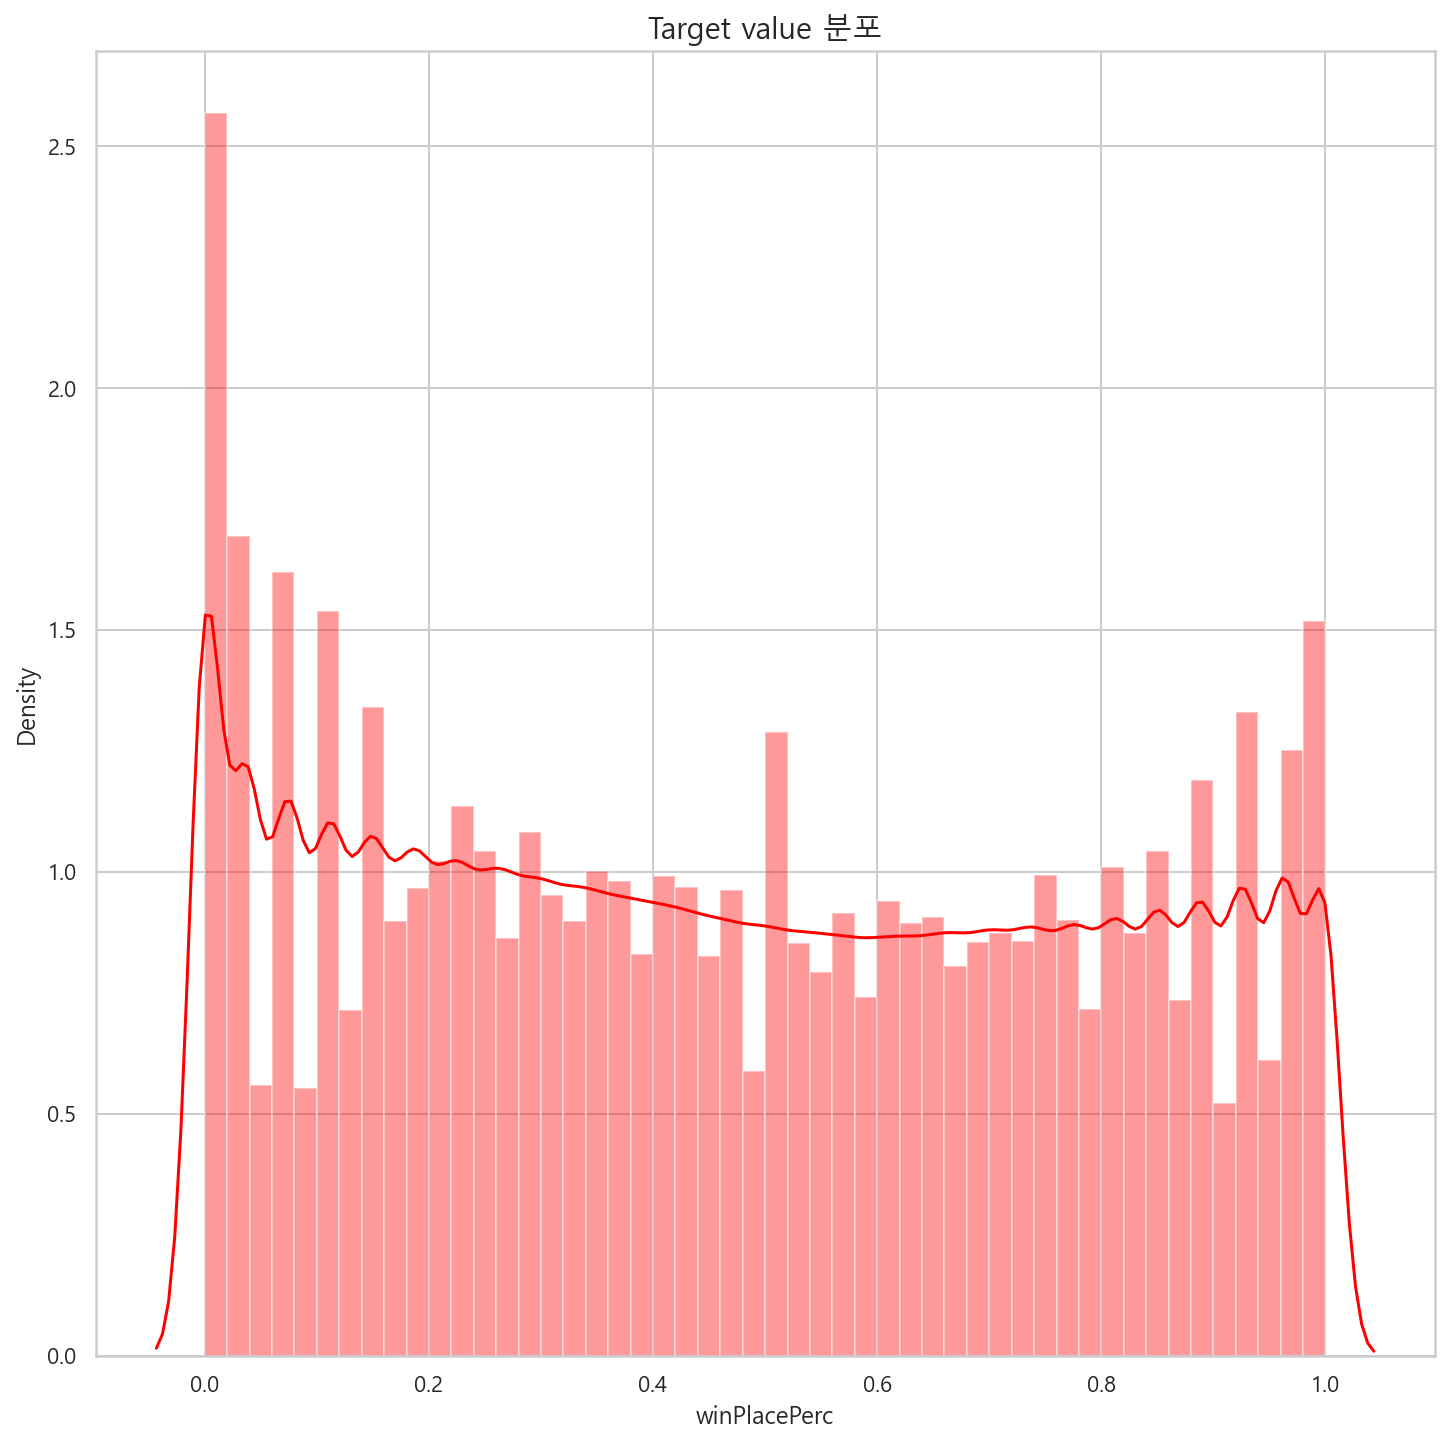

In [7]:
plt.figure(figsize=(12,12))
sns.distplot(train['winPlacePerc'], color = 'red')
plt.title('Target value 분포', fontsize = 15)
plt.savefig('target.png')

### 02-5 중복행 및 결측값 확인

In [8]:
#중복행 확인 - 없음
train[train.duplicated(keep='first')]

Empty DataFrame
Columns: [Id, groupId, matchId, assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, matchType, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

[0 rows x 29 columns]

In [5]:
#winPlacePerc 결측 확인
null_index = train[train['winPlacePerc'].isnull()==True].index
#결측값 있는 행 제거
train = train.drop(null_index)
#확인
train[train['winPlacePerc'].isnull()==True]

Empty DataFrame
Columns: [Id, groupId, matchId, assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, matchType, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

[0 rows x 29 columns]

In [24]:
#killPoints, winPoints 결측 비율 : 60%이므로 변수 삭제 고려
ratio = len(train[train['killPoints']==0])/len(train)*100
print('killPoints, winPoints 결측 비율 :','%.2f%%'%ratio)
print('rankPoints 결측 비율 :','%.2f%%'%(100-ratio))

killPoints, winPoints 결측 비율 : 59.72%
rankPoints 결측 비율 : 40.28%


### 02-6 상관관계

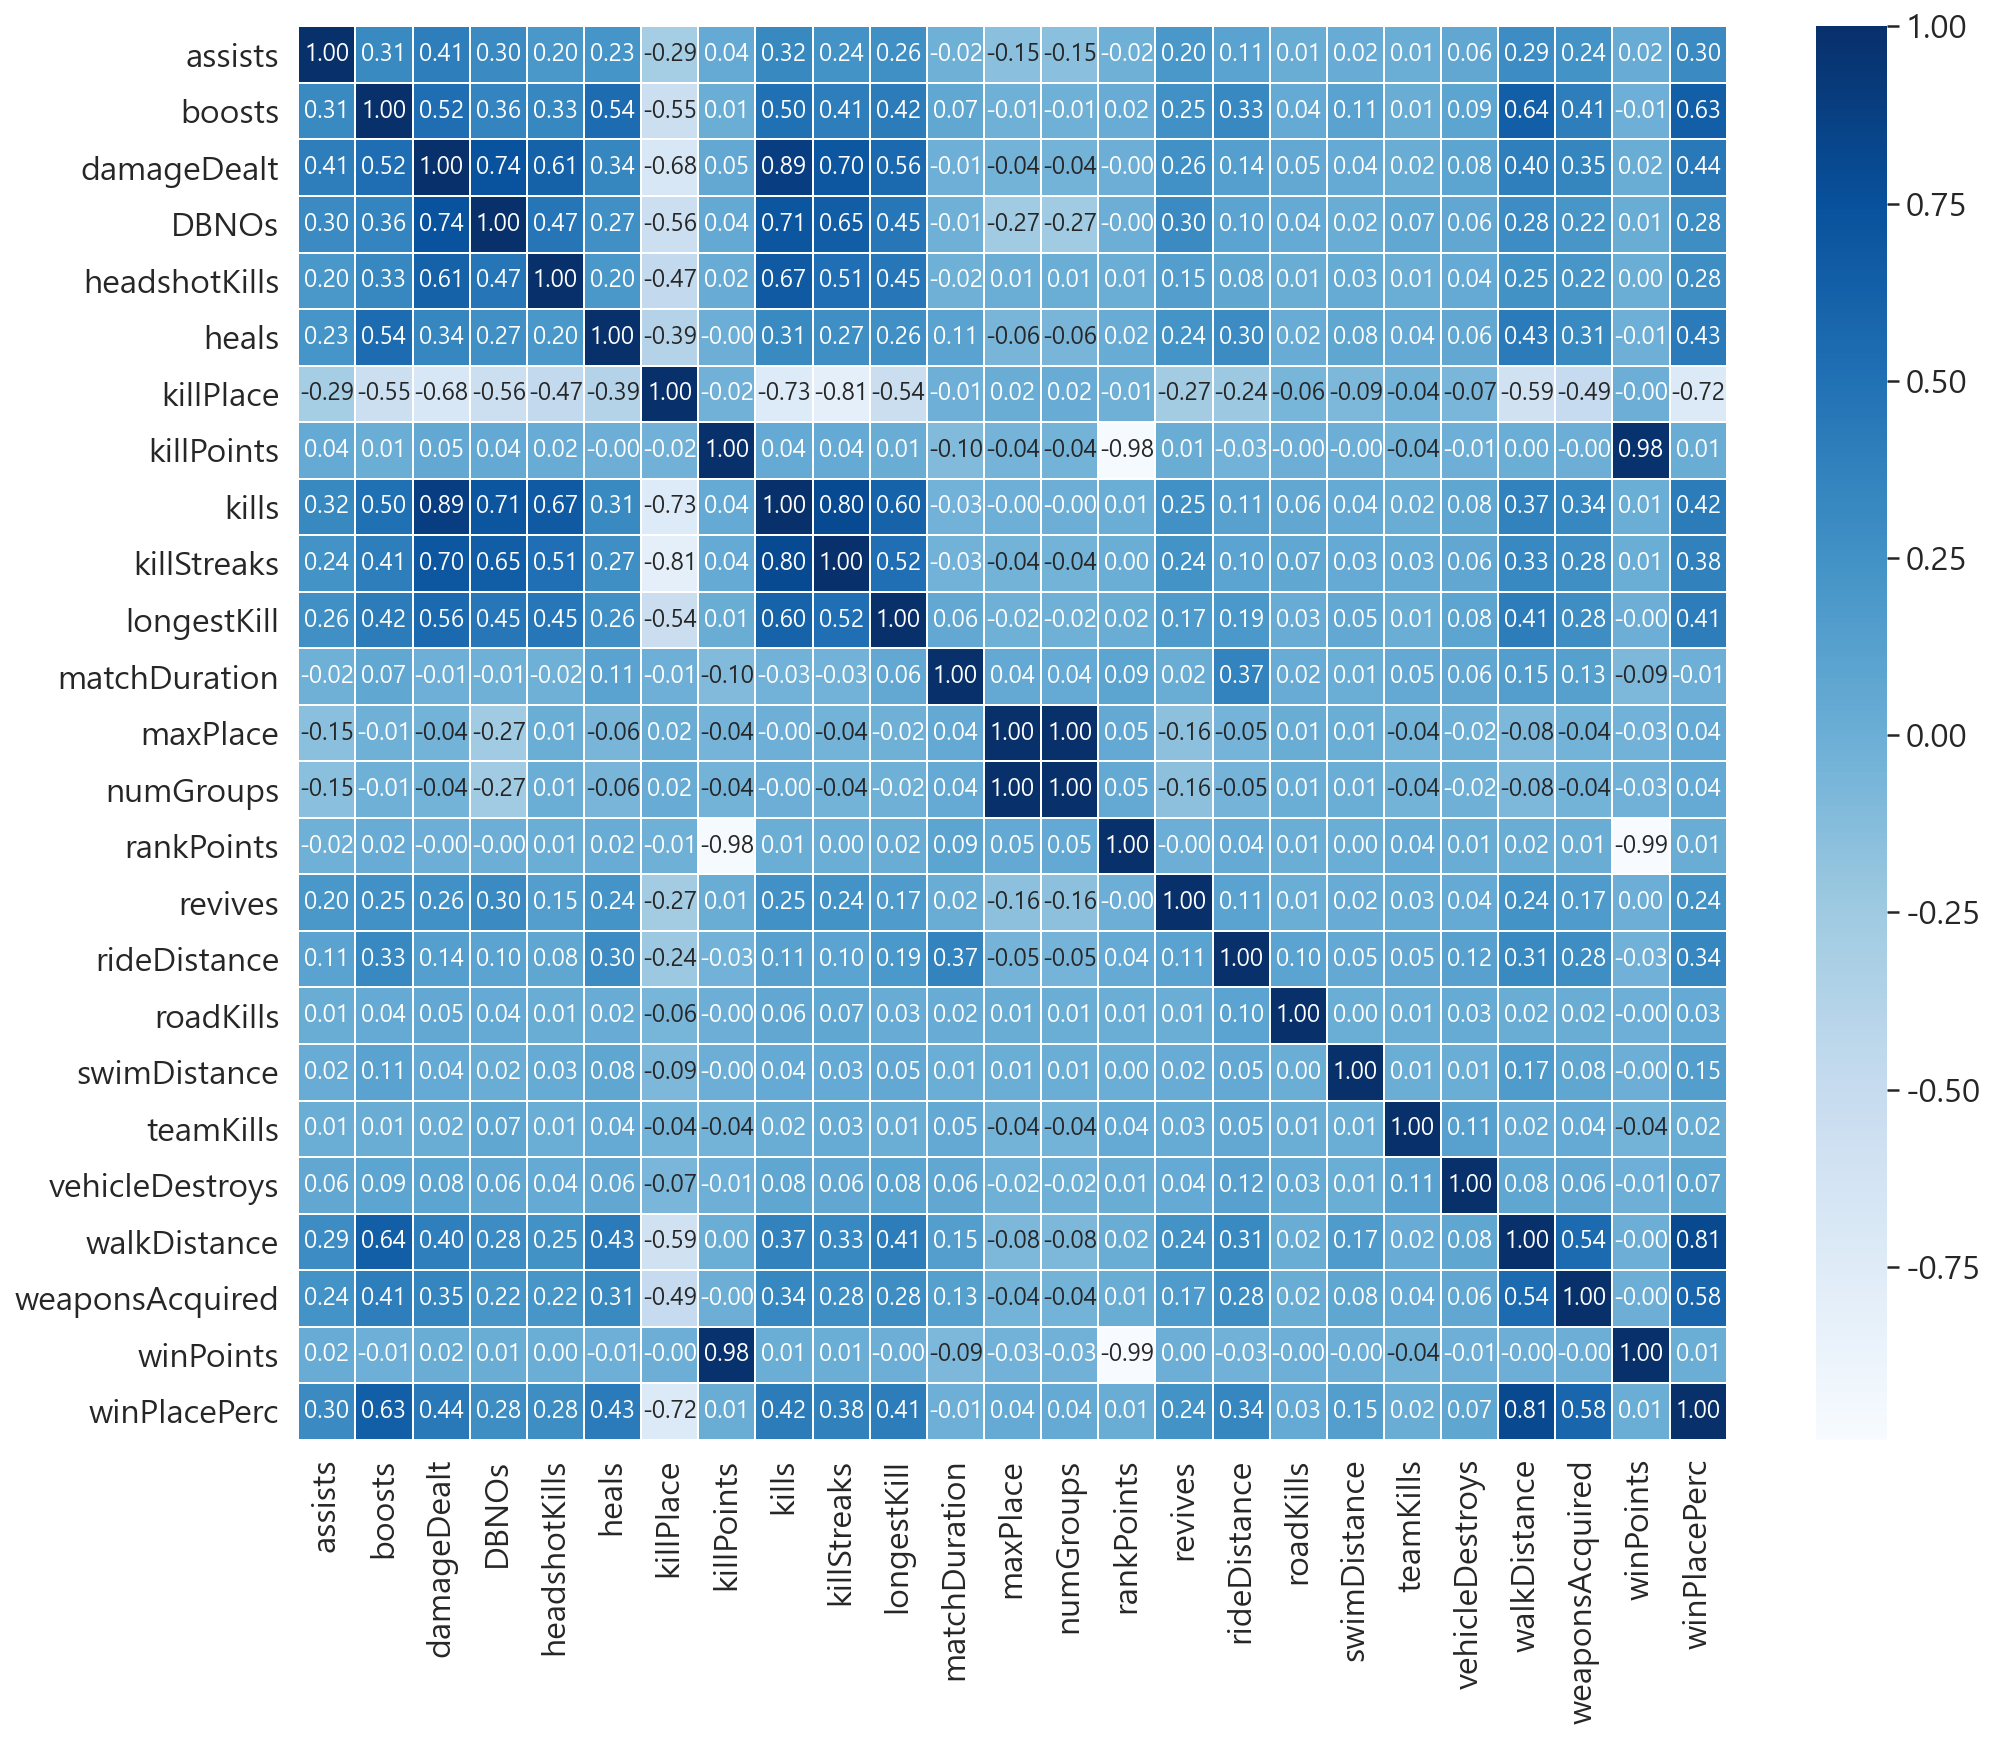

In [10]:
sns.set(font='Malgun Gothic', 
        rc={"axes.unicode_minus":False},
        style='whitegrid',
        font_scale=1.5)
plt.figure(figsize=(16,13))
sns.heatmap(data = train.drop(columns=['Id','groupId','matchId','matchType']).corr(), 
            annot=True, fmt = '.2f', linewidths=.5, cmap='Blues', annot_kws={"size": 12})
plt.savefig('corr.png')

#### 상관관계 특이점
1. rankPoints, killPoints, winPoints의 상관관계 절댓값이 거의 1에 가까움
-> killPoints와 winPoints는 거의 같은 변수이며, rankPoints의 값이 있을 때는 killPoints, winPoints 값이 결측이고 killPoints, winPoints 값이 있을 때는 rankPoints가 결측임

2. maxPlace와 numGroups의 상관관계가 1
-> 둘은 같은 변수이므로 numGroups 삭제

3. boosts, killPlace, walkDistance, weaponsAcquired가 target 변수와 높은 상관관계를 보임

### 02-7 분포 시각화

In [ ]:
columns = list(train.drop(columns = ['Id','matchId','groupId','matchType']).columns)

plt.figure(figsize=(16,24))
i = 0
for val in columns:
    plt.subplot(5,5,i+1)
    sns.distplot(train[val])
    i += 1    
    
plt.tight_layout()

<AxesSubplot:xlabel='weaponsAcquired', ylabel='Density'>

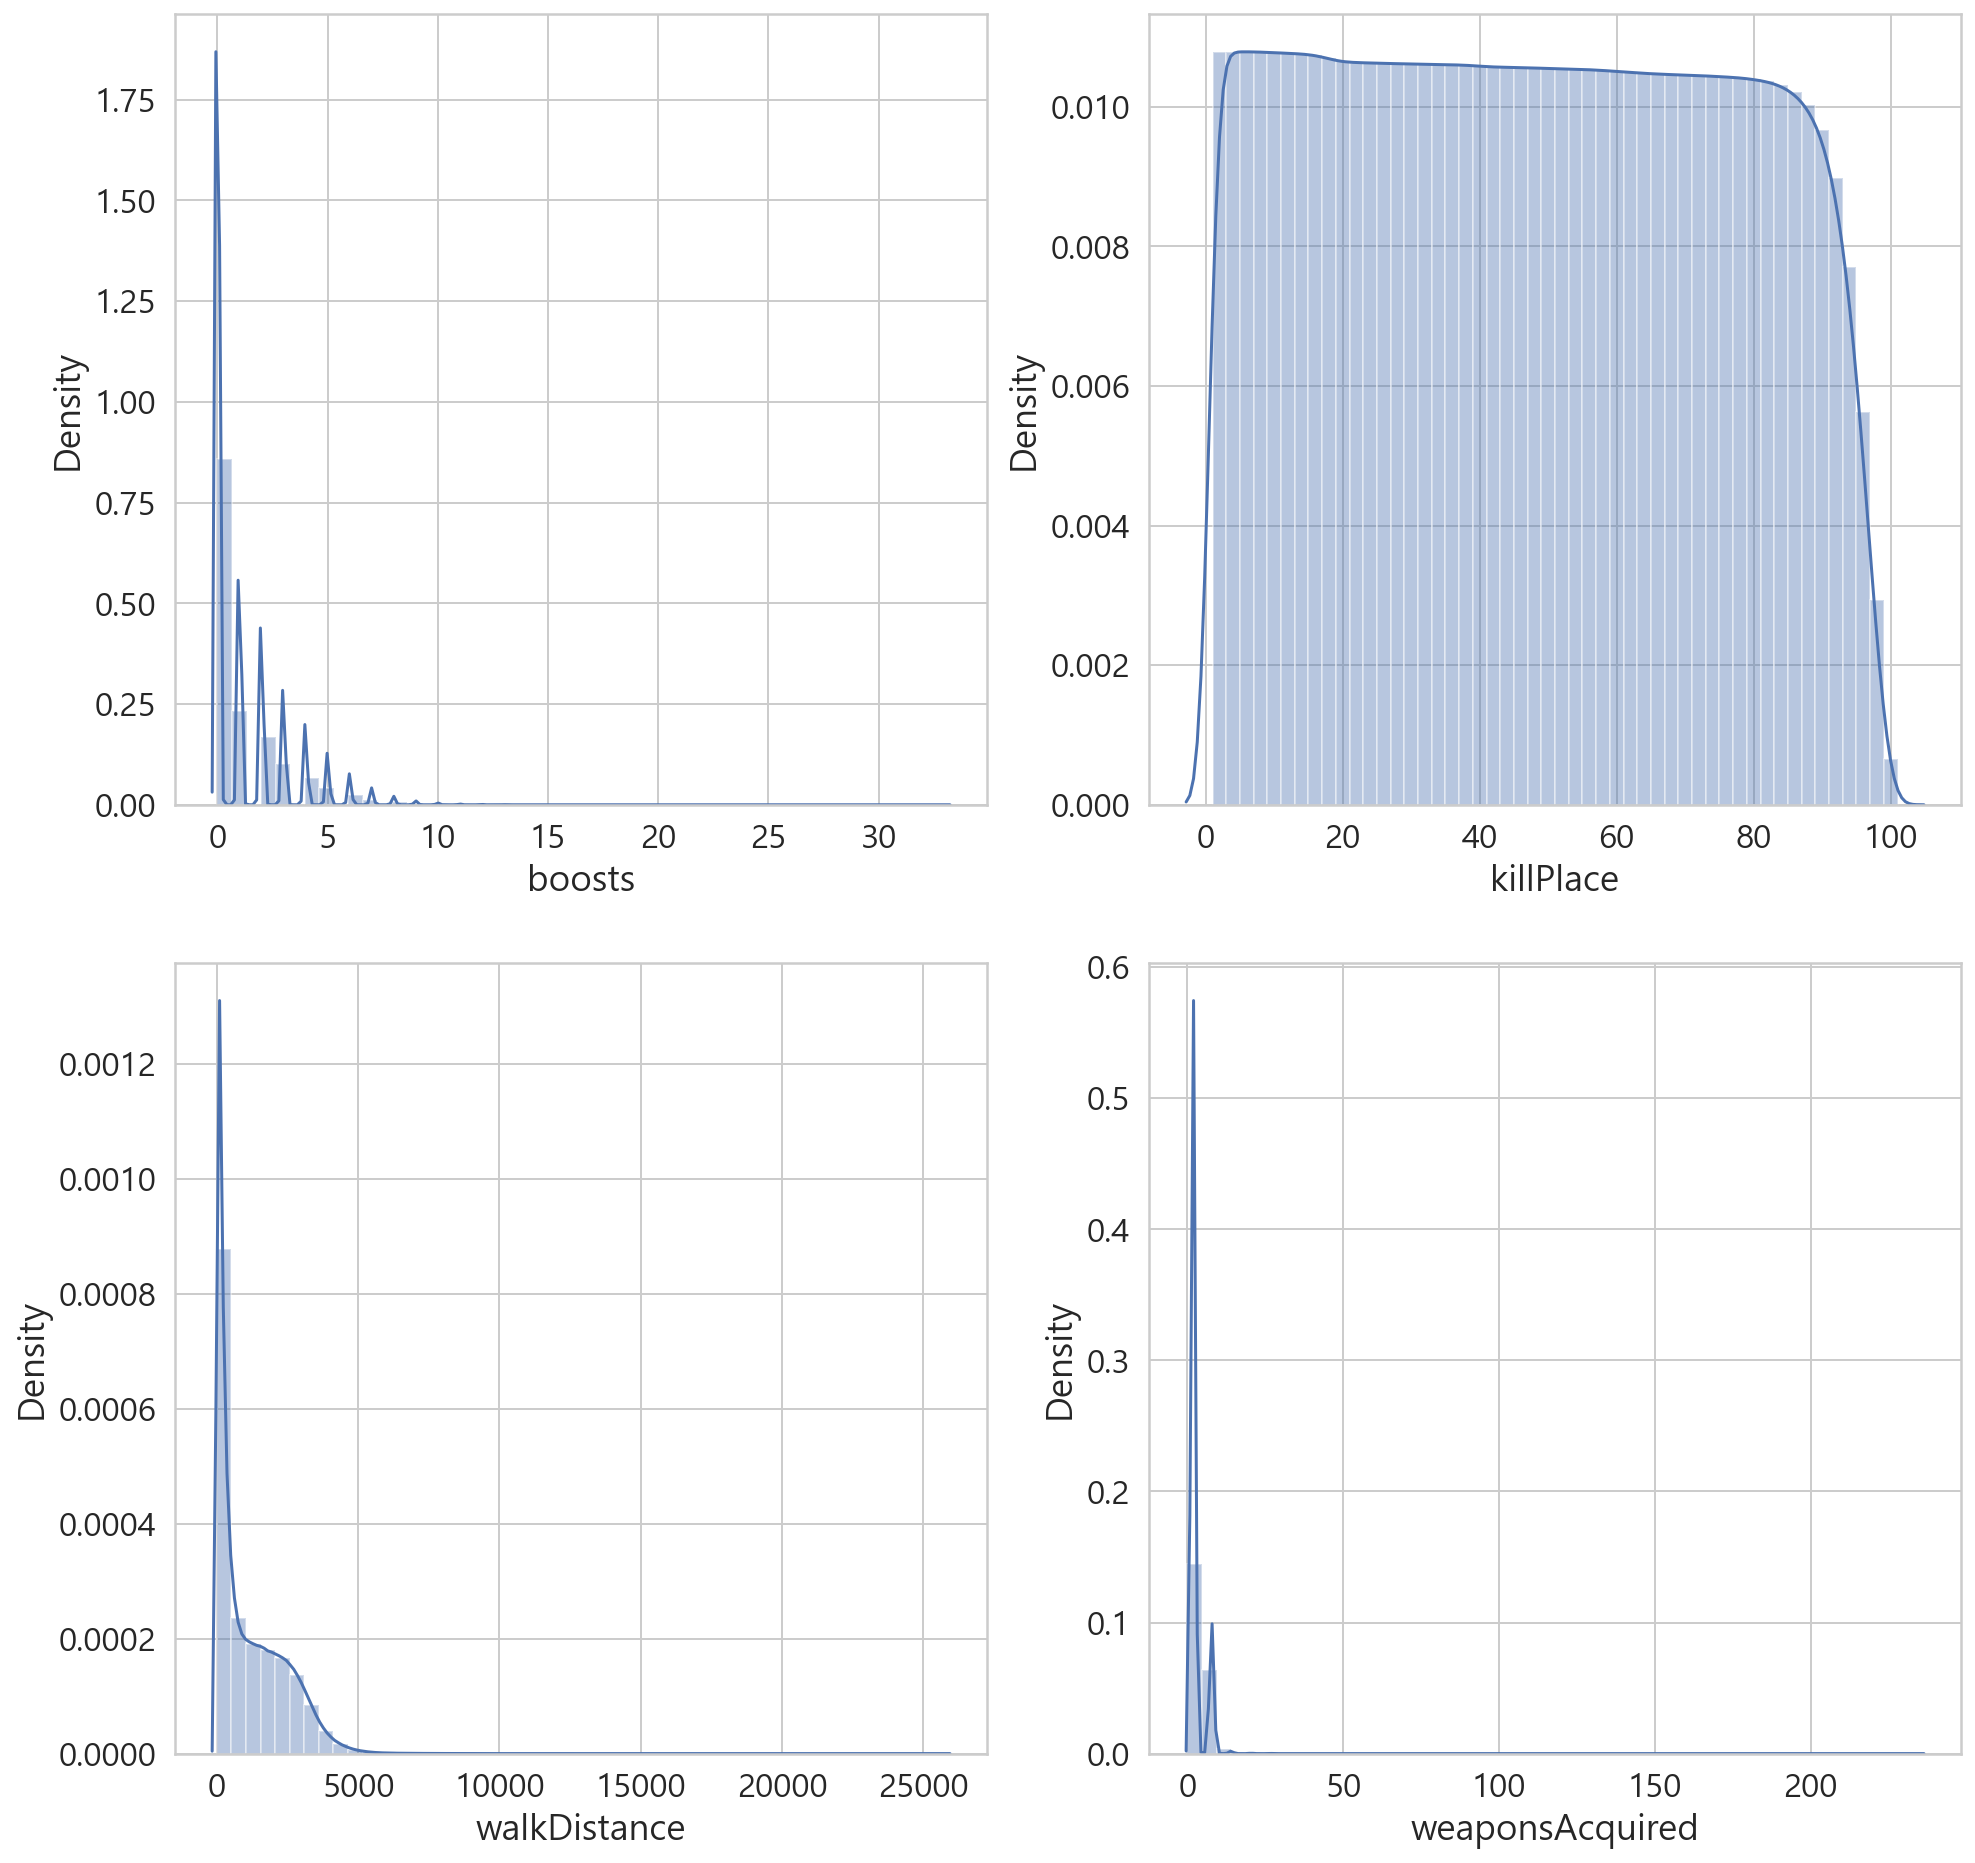

In [11]:
plt.figure(figsize=(16,16))

plt.subplot(221)
sns.distplot(train['boosts'])
plt.savefig('boosts.png')

plt.subplot(222)
sns.distplot(train['killPlace'])
plt.savefig('killPlace.png')

plt.subplot(223)
sns.distplot(train['walkDistance'])
plt.savefig('walkDistance.png')

plt.subplot(224)
sns.distplot(train['weaponsAcquired'])
plt.savefig('weaponsAcquired.png')

<AxesSubplot:xlabel='weaponsAcquired'>

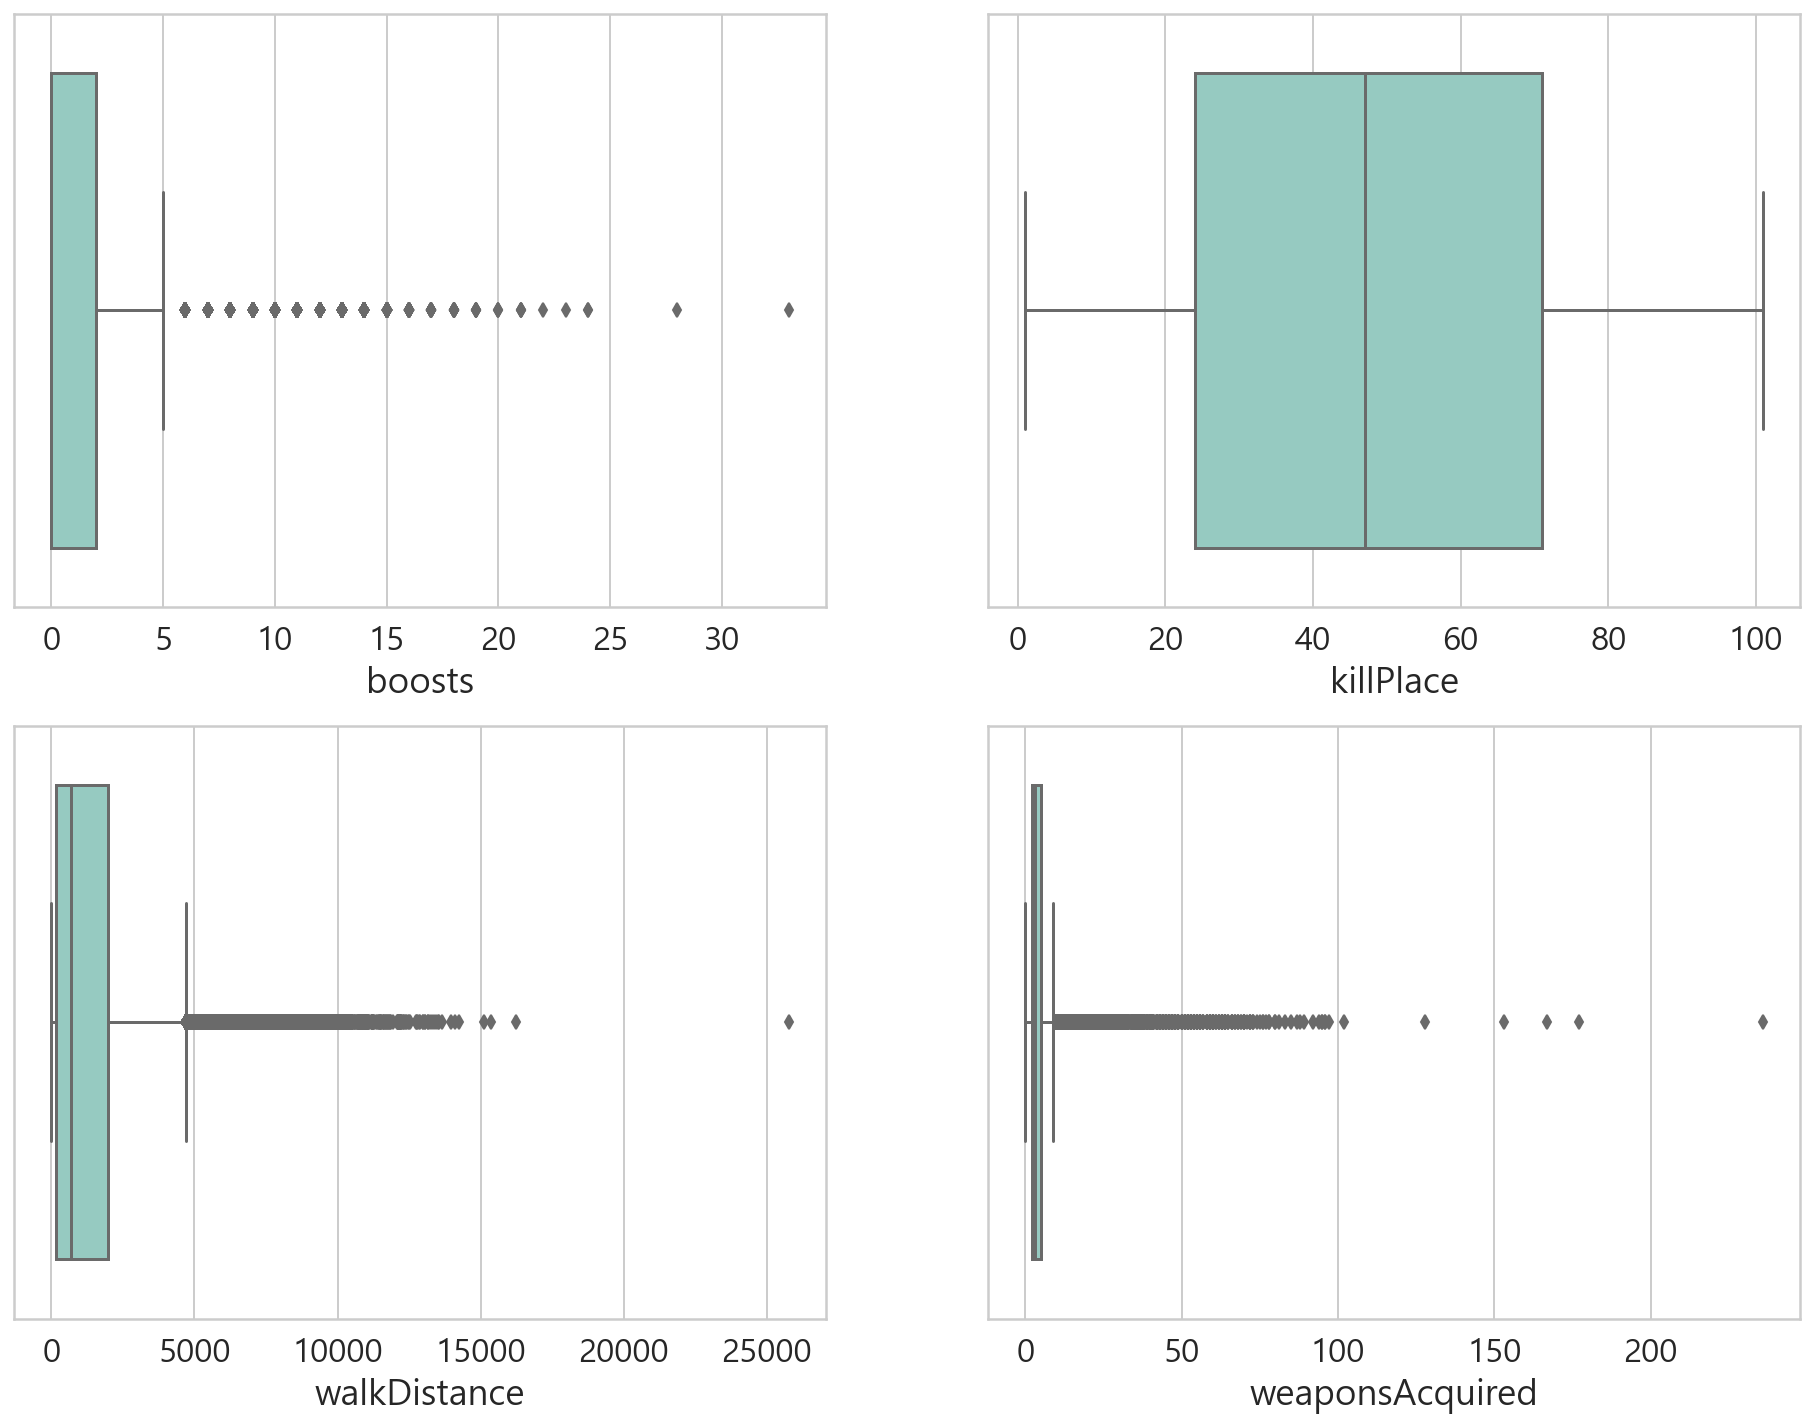

In [13]:
plt.figure(figsize=(16,12))
sns.set_palette('Set3')

plt.subplot(221)
sns.boxplot(train['boosts'])

plt.subplot(222)
sns.boxplot(train['killPlace'])

plt.subplot(223)
sns.boxplot(train['walkDistance'])

plt.subplot(224)
sns.boxplot(train['weaponsAcquired'])

### 02-8 변수중요도

In [ ]:
from sklearn.ensemble import RandomForestRegressor

x = train.iloc[:, :24]  
y = train.iloc[:, 24 ]

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rf.fit(x, y)

features = list(x.columns)

plt.figure(figsize = (12,10))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

#변수중요도 top 4 : walkDistance, killPlace, boosts, weaponsAcquired (0.04 이상)

### 02-9 다중공선성 확인 - VIF

In [ ]:
features='assists+boosts+damageDealt+DBNOs+headshotKills+heals+kills+killStreaks+longestKill+matchDuration+matchType+maxPlace+rankPoints+revives+rideDistance+swimDistance+teamKills+weaponsAcquired+walkDistancePerc+matchMode+Distance+killPerc+killsRatio+walkPerDuration+DistancePerDuration+killPlacePerc'

y, X = dmatrices("winPlacePerc~" + features, data=df, return_type="dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif.sort_values('VIF Factor', ascending=False)

## 03 데이터 전처리

### 03-1 matchType 재범주화 -> matchMode 변수 생성

In [10]:
#새로운 변수 matchMode(1~5)
newtrain = train.copy()
newtrain['matchType'] = newtrain['matchType'].astype('object')

# solo = 1
newtrain.loc[newtrain['matchType']=='solo','matchMode']=1
newtrain.loc[newtrain['matchType']=='solo-fpp','matchMode']=1
newtrain.loc[newtrain['matchType']=='normal-solo','matchMode']=1
newtrain.loc[newtrain['matchType']=='normal-solo-fpp','matchMode']=1

# duo = 2
newtrain.loc[newtrain['matchType']=='duo','matchMode']=2
newtrain.loc[newtrain['matchType']=='duo-fpp','matchMode']=2
newtrain.loc[newtrain['matchType']=='normal-duo','matchMode']=2
newtrain.loc[newtrain['matchType']=='normal-duo-fpp','matchMode']=2

# sqaud = 3
newtrain.loc[newtrain['matchType']=='squad','matchMode']=3
newtrain.loc[newtrain['matchType']=='squad-fpp','matchMode']=3
newtrain.loc[newtrain['matchType']=='normal-squad','matchMode']=3
newtrain.loc[newtrain['matchType']=='normal-squad-fpp','matchMode']=3

# crash = 4
newtrain.loc[newtrain['matchType']=='crashfpp','matchMode']=4
newtrain.loc[newtrain['matchType']=='crashtpp','matchMode']=4

# flare = 5
newtrain.loc[newtrain['matchType']=='flarefpp','matchMode']=5
newtrain.loc[newtrain['matchType']=='flaretpp','matchMode']=5

#matchType 재범주화(1~7)
x = newtrain['matchType']
newtrain['matchType'] = list(map(lambda u: 1 if u == 'solo' else u, x))
newtrain['matchType'] = list(map(lambda u: 2 if u == 'duo' else u, x))
newtrain['matchType'] = list(map(lambda u: 3 if u == 'squad' else u, x))
newtrain['matchType'] = list(map(lambda u: 4 if u == 'solo-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 5 if u == 'duo-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 6 if u == 'squad-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-squad-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'crashfpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'flaretpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-solo-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'flarefpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-duo-fpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-duo' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-squad' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'crashtpp' else u, x))
newtrain['matchType'] = list(map(lambda u: 7 if u == 'normal-solo' else u, x))

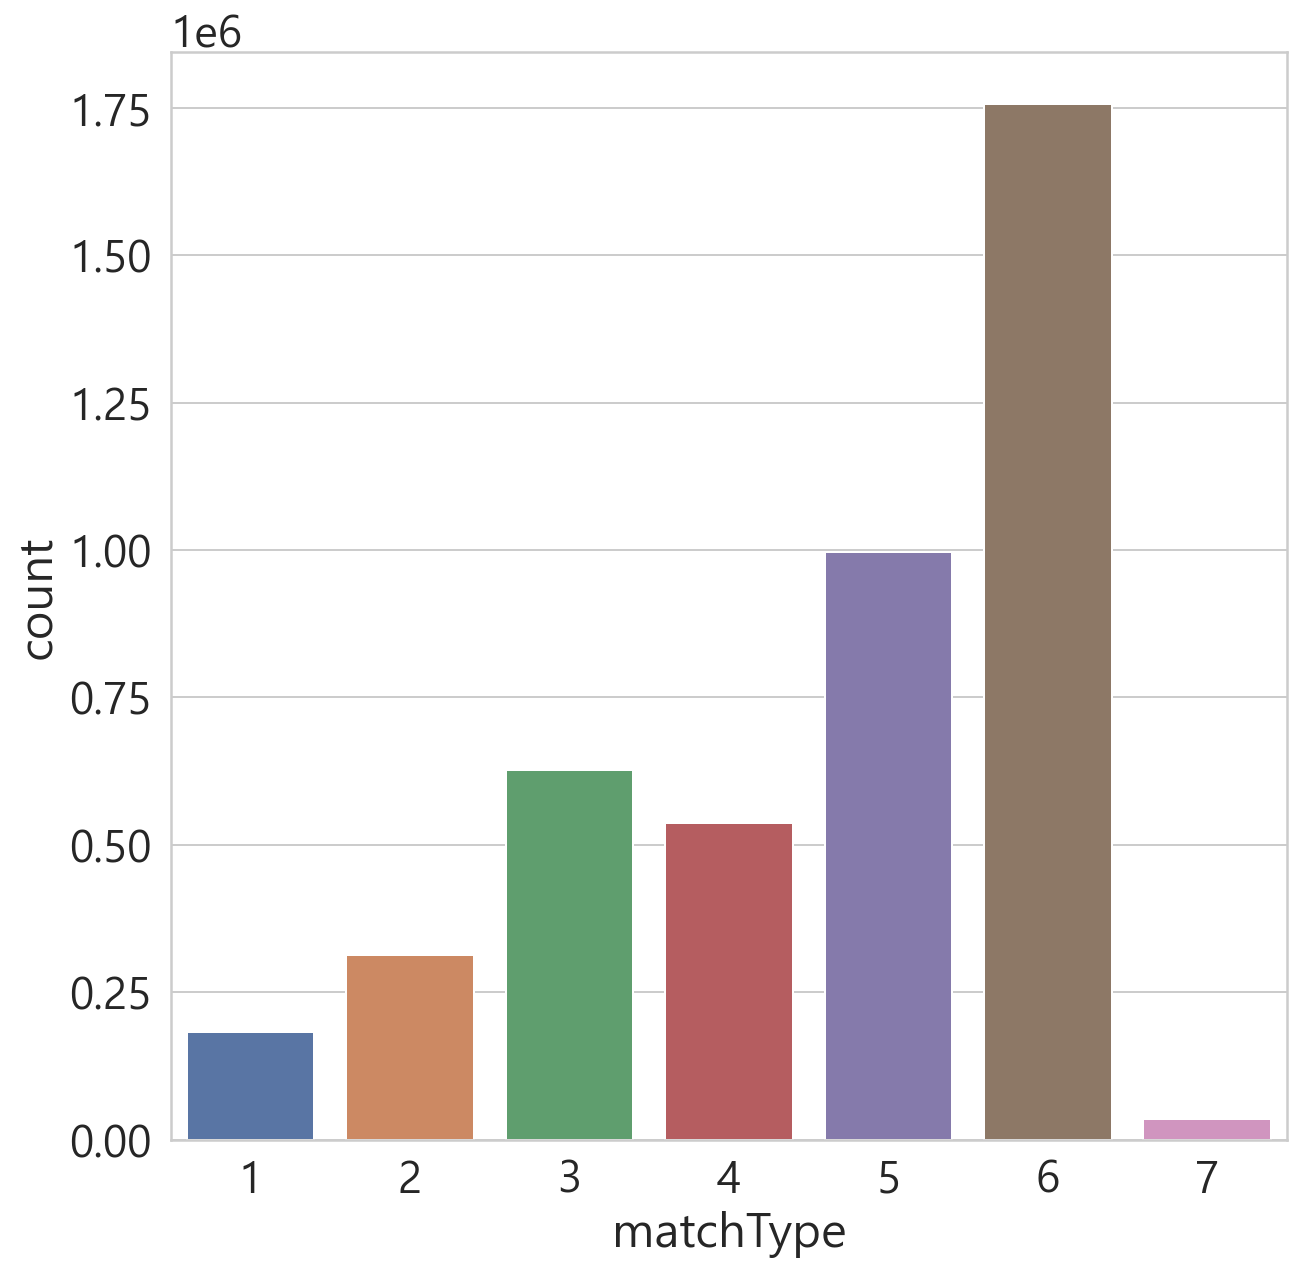

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(newtrain['matchType'])

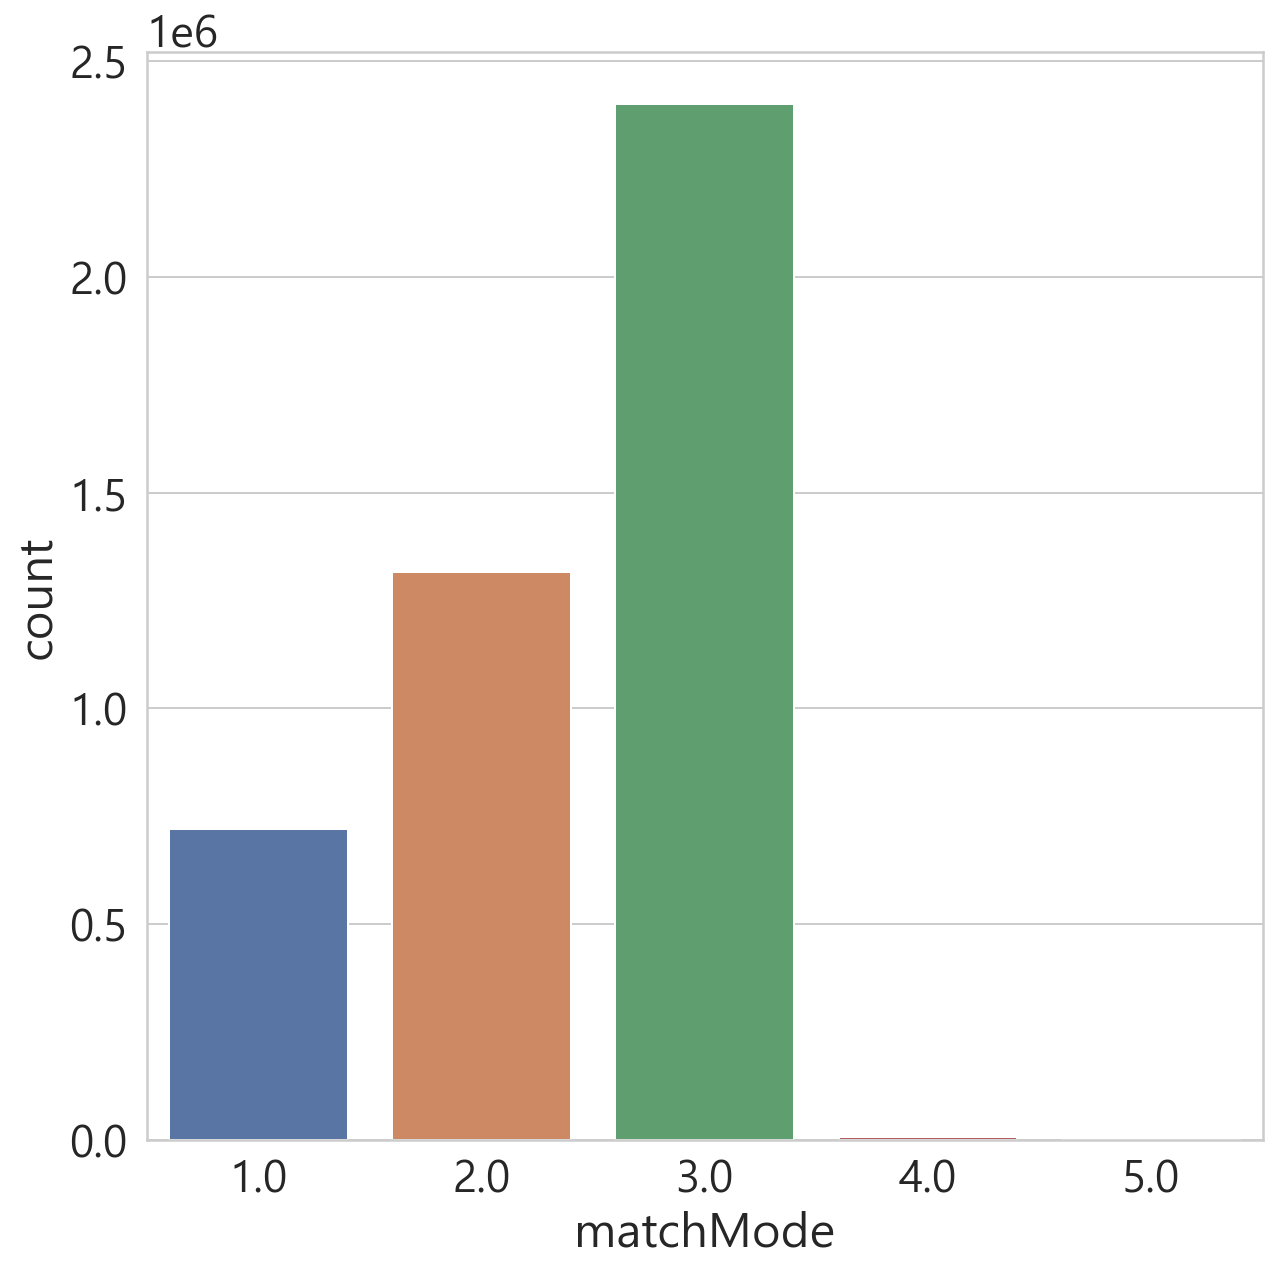

In [15]:
plt.figure(figsize=(10,10))
sns.countplot(newtrain['matchMode'])

### 03-2 파생변수 생성

In [17]:
# 총 이동거리 Distance 변수 생성
newtrain['Distance'] = newtrain['walkDistance'] + newtrain['rideDistance'] + newtrain['swimDistance']

# kill 수를 기준으로 한 백분율 변수 생성
newtrain['killPerc'] = newtrain.groupby('matchId')['kills'].rank(pct=True).values

# 도보 거리 당 kill 변수 생성(walkDistance 0 삭제)
dist_null = newtrain[newtrain.walkDistance == 0].index
newtrain = newtrain.drop(dist_null)
newtrain['killsRatio'] = newtrain['kills'] / newtrain['walkDistance']

# 소요 시간당 도보 거리 변수 생성
newtrain['walkPerDuration'] =  newtrain["walkDistance"]/newtrain["matchDuration"]

# 소요 시간당 이동 거리 변수 생성
newtrain['DistancePerDuration'] =  newtrain["Distance"]/newtrain["matchDuration"]

# kill 랭킹 백분율 변수 생성
newtrain['killPlacePerc'] = newtrain.groupby('matchId')['killPlace'].rank(pct=True).values

# 도보 거리 기준 백분율 변수 생성
newtrain['walkDistancePerc'] = newtrain.groupby('matchId')['walkDistance'].rank(pct=True).values

newtrain = newtrain.drop(columns=['Id', 'matchId', 'groupId'])

In [9]:
#분산 0 확인 : roadKills, vehicleDestroys 제거
columns = list(newtrain.columns)
var = []

for val in columns:
    var.append(newtrain[val].var())

var_df = pd.DataFrame({'열' : columns, '분산' : var})
var_df.분산 = var_df.분산.astype('float64')
var_df = var_df.sort_values(by='분산',ascending=True)
var_df

열              분산
29           killsRatio       0.0033828
18            roadKills       0.0055037
21      vehicleDestroys       0.0087715
20            teamKills       0.0281917
28             killPerc       0.0671388
33     walkDistancePerc       0.0833323
32        killPlacePerc       0.0833326
25         winPlacePerc       0.0912853
16              revives       0.2272968
0               assists       0.3508724
4         headshotKills       0.3678772
9           killStreaks       0.5096106
30      walkPerDuration       0.5553650
26            matchMode       0.5623209
3                 DBNOs       1.3287613
31  DistancePerDuration       1.5203520
12            matchType       2.2402184
8                 kills       2.4465916
1                boosts       2.9823427
23      weaponsAcquired       5.7915701
5                 heals       7.2990691
14            numGroups     536.1646495
13             maxPlace     562.6828466
6             killPlace     731.7331397
19         swimDistance     933.9702148
10          longestKill    2679.4577637
2           damageDealt   28874.9765625
11        matchDuration   66818.2989204
7            killPoints  395008.4597856
15           rankPoints  543158.9464819
24            winPoints  548528.5811471
22         walkDistance 1396118.5000000
17         rideDistance 2273004.5000000
27             Distance 4774829.0000000

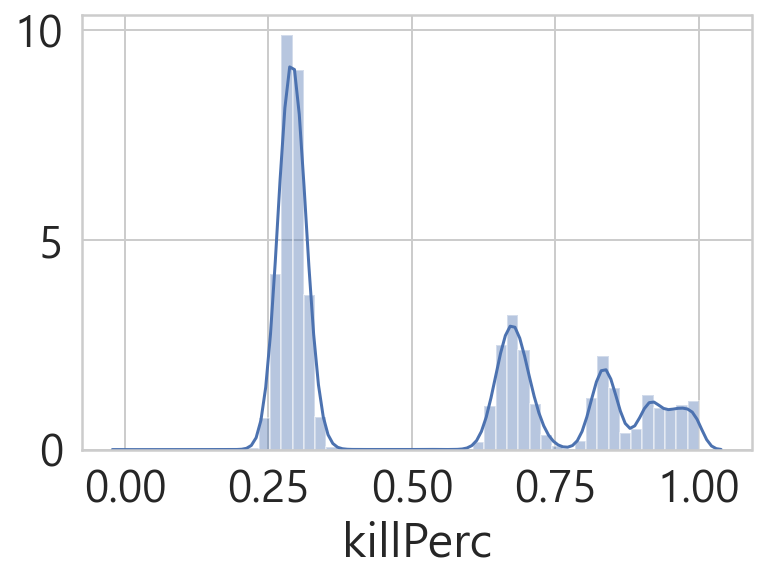

In [27]:
sns.distplot(newtrain['killPerc'])

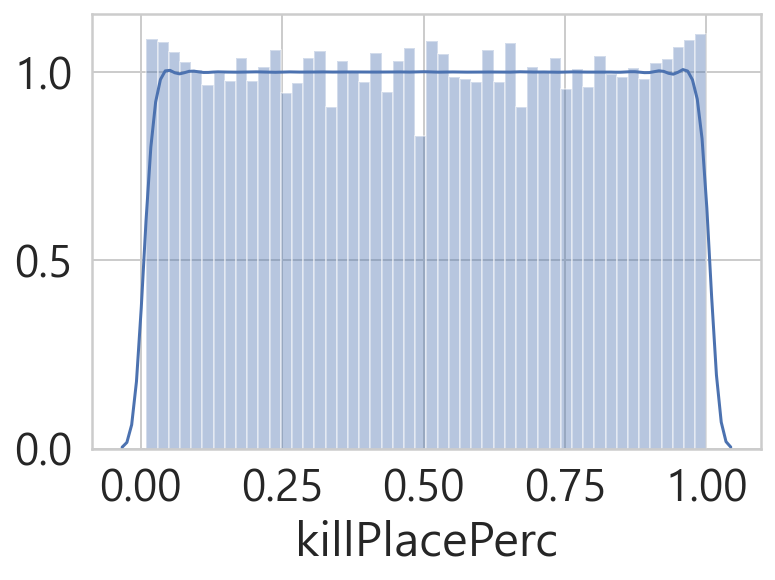

In [28]:
sns.distplot(newtrain['killPlacePerc'])

### 03-3 rankPoints 결측 killPoints 값으로 대체

In [18]:
# rankPoints = rankPoints + killPoints (결측을 killPoints로 메꿔줌)
newtrain['rankPoints'] = newtrain.rankPoints + newtrain.killPoints

### 03-4 이상치 대체

In [24]:
#이상치 대체 함수
def replace_outlier(df_cp, column):
    df = df_cp[column]
    
    quantile_01 = np.percentile(df.values, 1)
    quantile_99 = np.percentile(df.values, 99)      
      
    outlier_low = df[df < quantile_01].index
    outlier_high = df[df > quantile_99].index
    
    print(column, 'outlier 개수 :' ,len(outlier_low)+len(outlier_high),'\n')
    
    df_cp[column][outlier_low] = quantile_01
    df_cp[column][outlier_high]= quantile_99
    
    return df_cp

def replace_outlier2 (df_cp, column):
    normal = df_cp[column]
    
    quantile_25 = np.percentile(normal.values, 25)
    quantile_75 = np.percentile(normal.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr = iqr * 3
        
    lowest  = quantile_25 - iqr
    highest = quantile_75 + iqr
             
    outlier_low = normal[normal < lowest].index
    outlier_high = normal[normal> highest].index
    
    print(column, 'outlier 개수 :' ,len(outlier_low)+len(outlier_high),'\n')
    
    df_cp[column][outlier_low] = lowest
    df_cp[column][outlier_high]= highest 
    
    return df_cp

def replace_outlier3 (df_cp, column):
    normal = df_cp[column]
    
    quantile_25 = np.percentile(normal.values, 25)
    quantile_75 = np.percentile(normal.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr = iqr * 1.5
        
    lowest  = quantile_25 - iqr
    highest = quantile_75 + iqr
             
    outlier_low = normal[normal < lowest].index
    outlier_high = normal[normal> highest].index
    
    print(column, 'outlier 개수 :' ,len(outlier_low)+len(outlier_high),'\n')
    
    df_cp[column][outlier_low] = lowest
    df_cp[column][outlier_high]= highest 
    
    return df_cp

def maxPlace_outlier2(df_cp):
    count = 0
    outlier_low = df_cp[(df_cp['matchMode']==1)&(df_cp['maxPlace'] < 85)].index
    outlier_high = df_cp[(df_cp['matchMode']==1)&(df_cp['maxPlace'] > 100)].index
    
    count = count + len(outlier_low) + len(outlier_high)
    
    df_cp['maxPlace'][outlier_low] = 85
    df_cp['maxPlace'][outlier_high] = 100 
    
    outlier_low = df_cp[(df_cp['matchMode']==2)&(df_cp['maxPlace'] < 41)].index
    outlier_high = df_cp[(df_cp['matchMode']==2)&(df_cp['maxPlace'] > 55)].index
    
    count = count + len(outlier_low) + len(outlier_high)
    
    df_cp['maxPlace'][outlier_low] = 41
    df_cp['maxPlace'][outlier_high] = 55 
    
    outlier_low = df_cp[(df_cp['matchMode']==3)&(df_cp['maxPlace'] < 21)].index
    outlier_high = df_cp[(df_cp['matchMode']==3)&(df_cp['maxPlace'] > 35)].index
    
    count = count + len(outlier_low) + len(outlier_high)
    
    df_cp['maxPlace'][outlier_low] = 21
    df_cp['maxPlace'][outlier_high] = 35 
    
    outlier_low = df_cp[(df_cp['matchMode']==4)&(df_cp['maxPlace'] < 38)].index
    outlier_high = df_cp[(df_cp['matchMode']==4)&(df_cp['maxPlace'] > 55)].index
    
    count = count + len(outlier_low) + len(outlier_high)
    
    df_cp['maxPlace'][outlier_low] = 38
    df_cp['maxPlace'][outlier_high] = 55 
    
    outlier_low = df_cp[(df_cp['matchMode']==5)&(df_cp['maxPlace'] < 15)].index
    outlier_high = df_cp[(df_cp['matchMode']==5)&(df_cp['maxPlace'] > 36)].index
    
    count = count + len(outlier_low) + len(outlier_high)
    
    df_cp['maxPlace'][outlier_low] = 15
    df_cp['maxPlace'][outlier_high] = 36 
    
    print('maxPlace', 'outlier 개수 :' , count,'\n')
    
    return df_cp

#### 이상치 대체, 로그 변환 전 분포

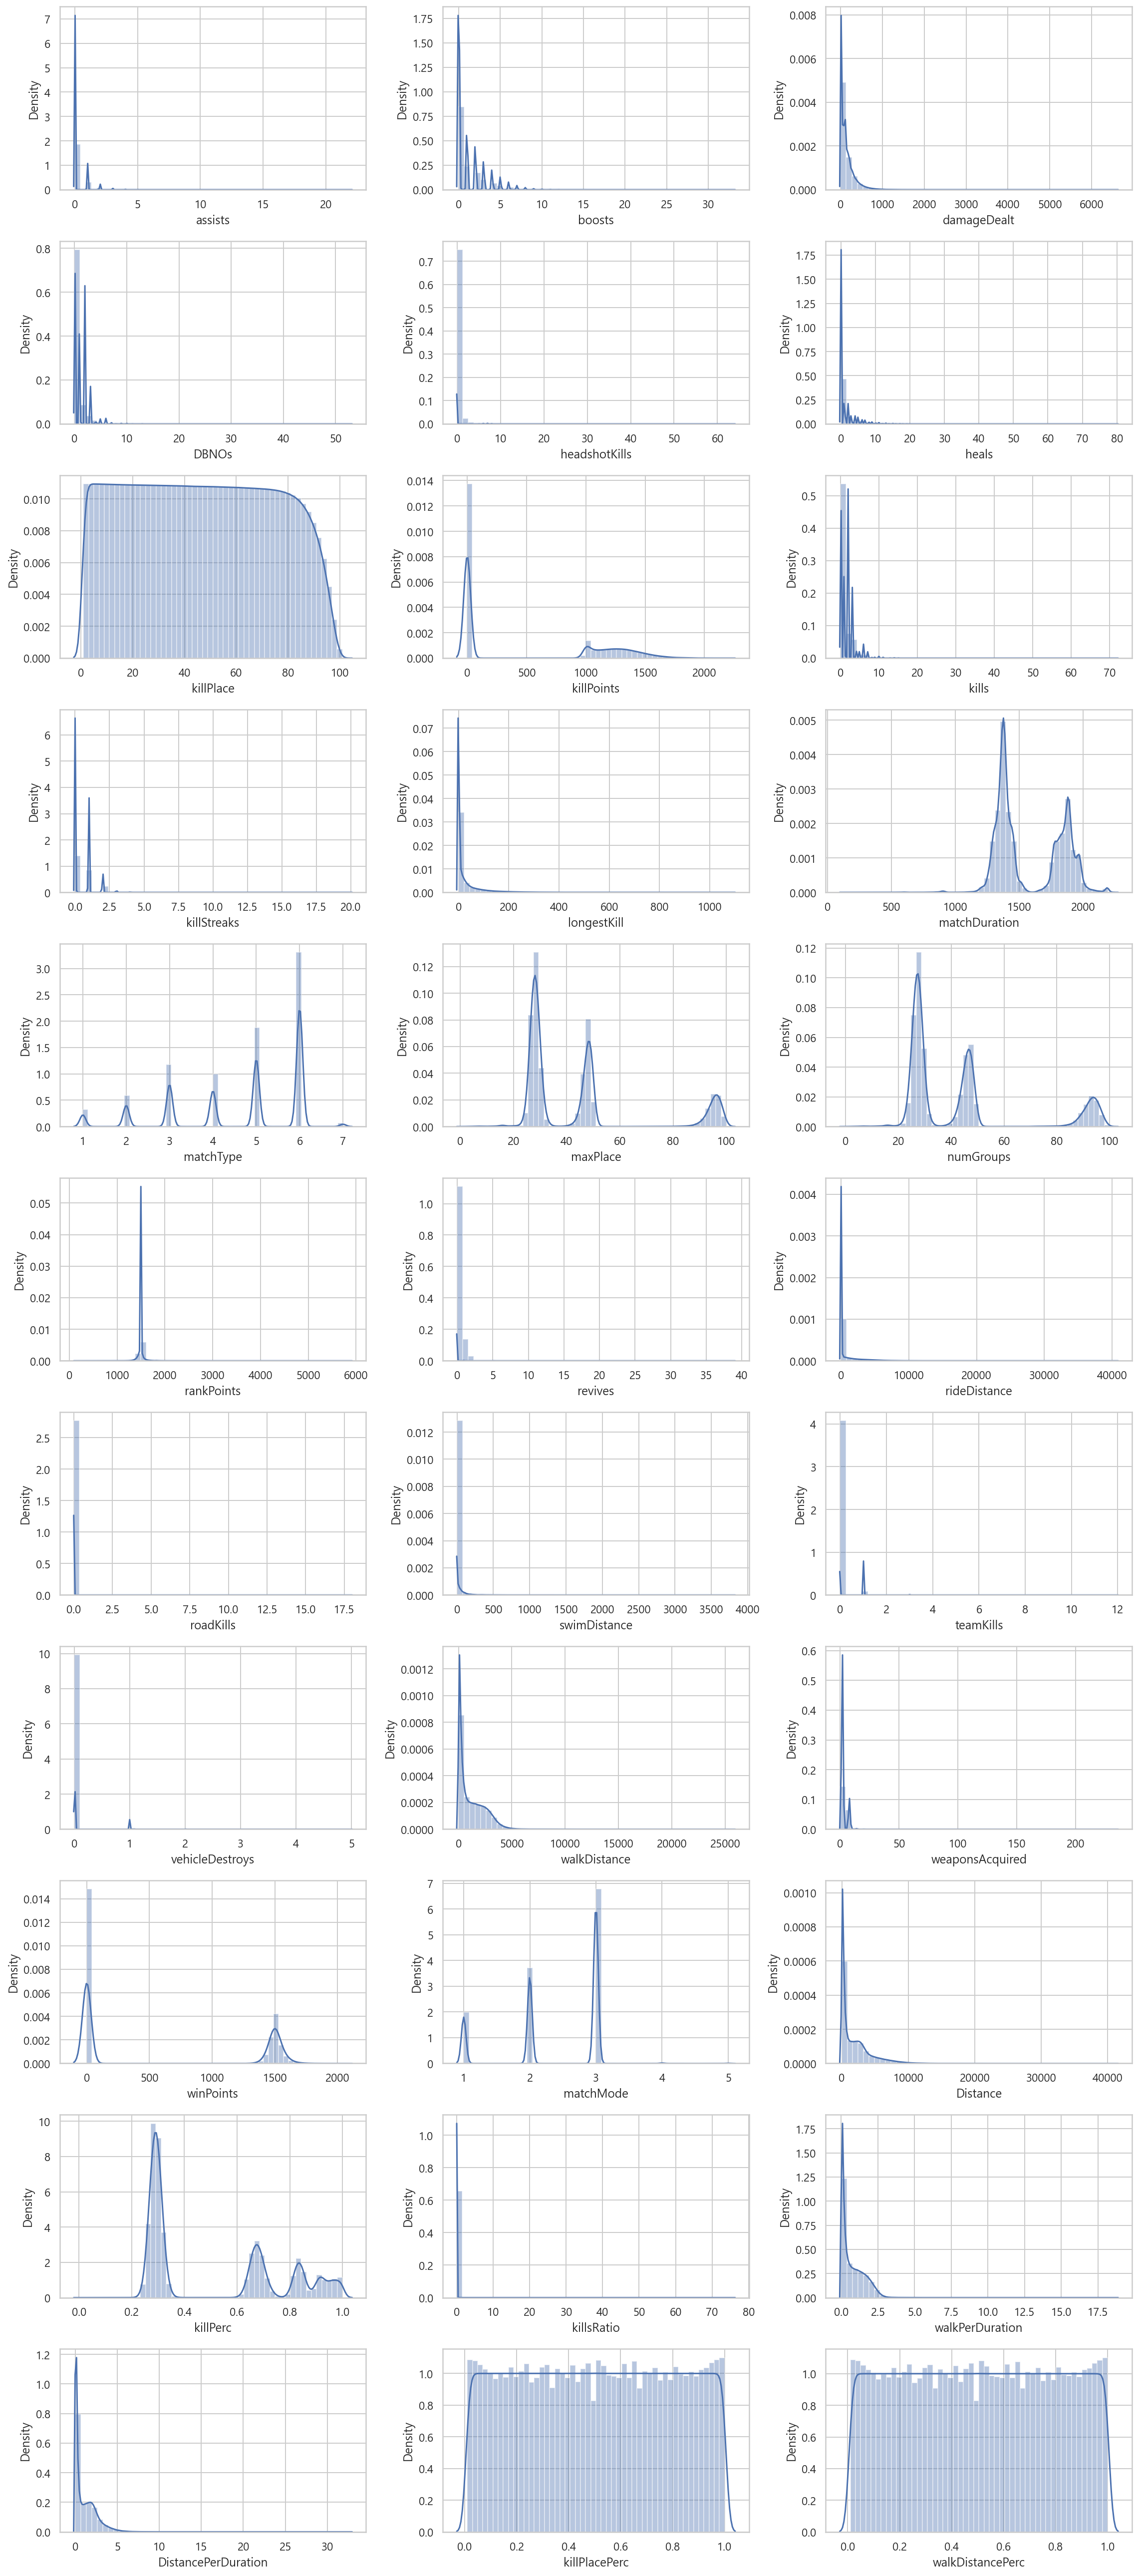

In [13]:
columns = list(newtrain.columns)
columns.remove('winPlacePerc')

plt.figure(figsize=(16,36))
i = 0
for val in columns:
    plt.subplot(11,3,i+1)
    sns.distplot(newtrain[val])
    i += 1    
    
plt.tight_layout()

<AxesSubplot:>

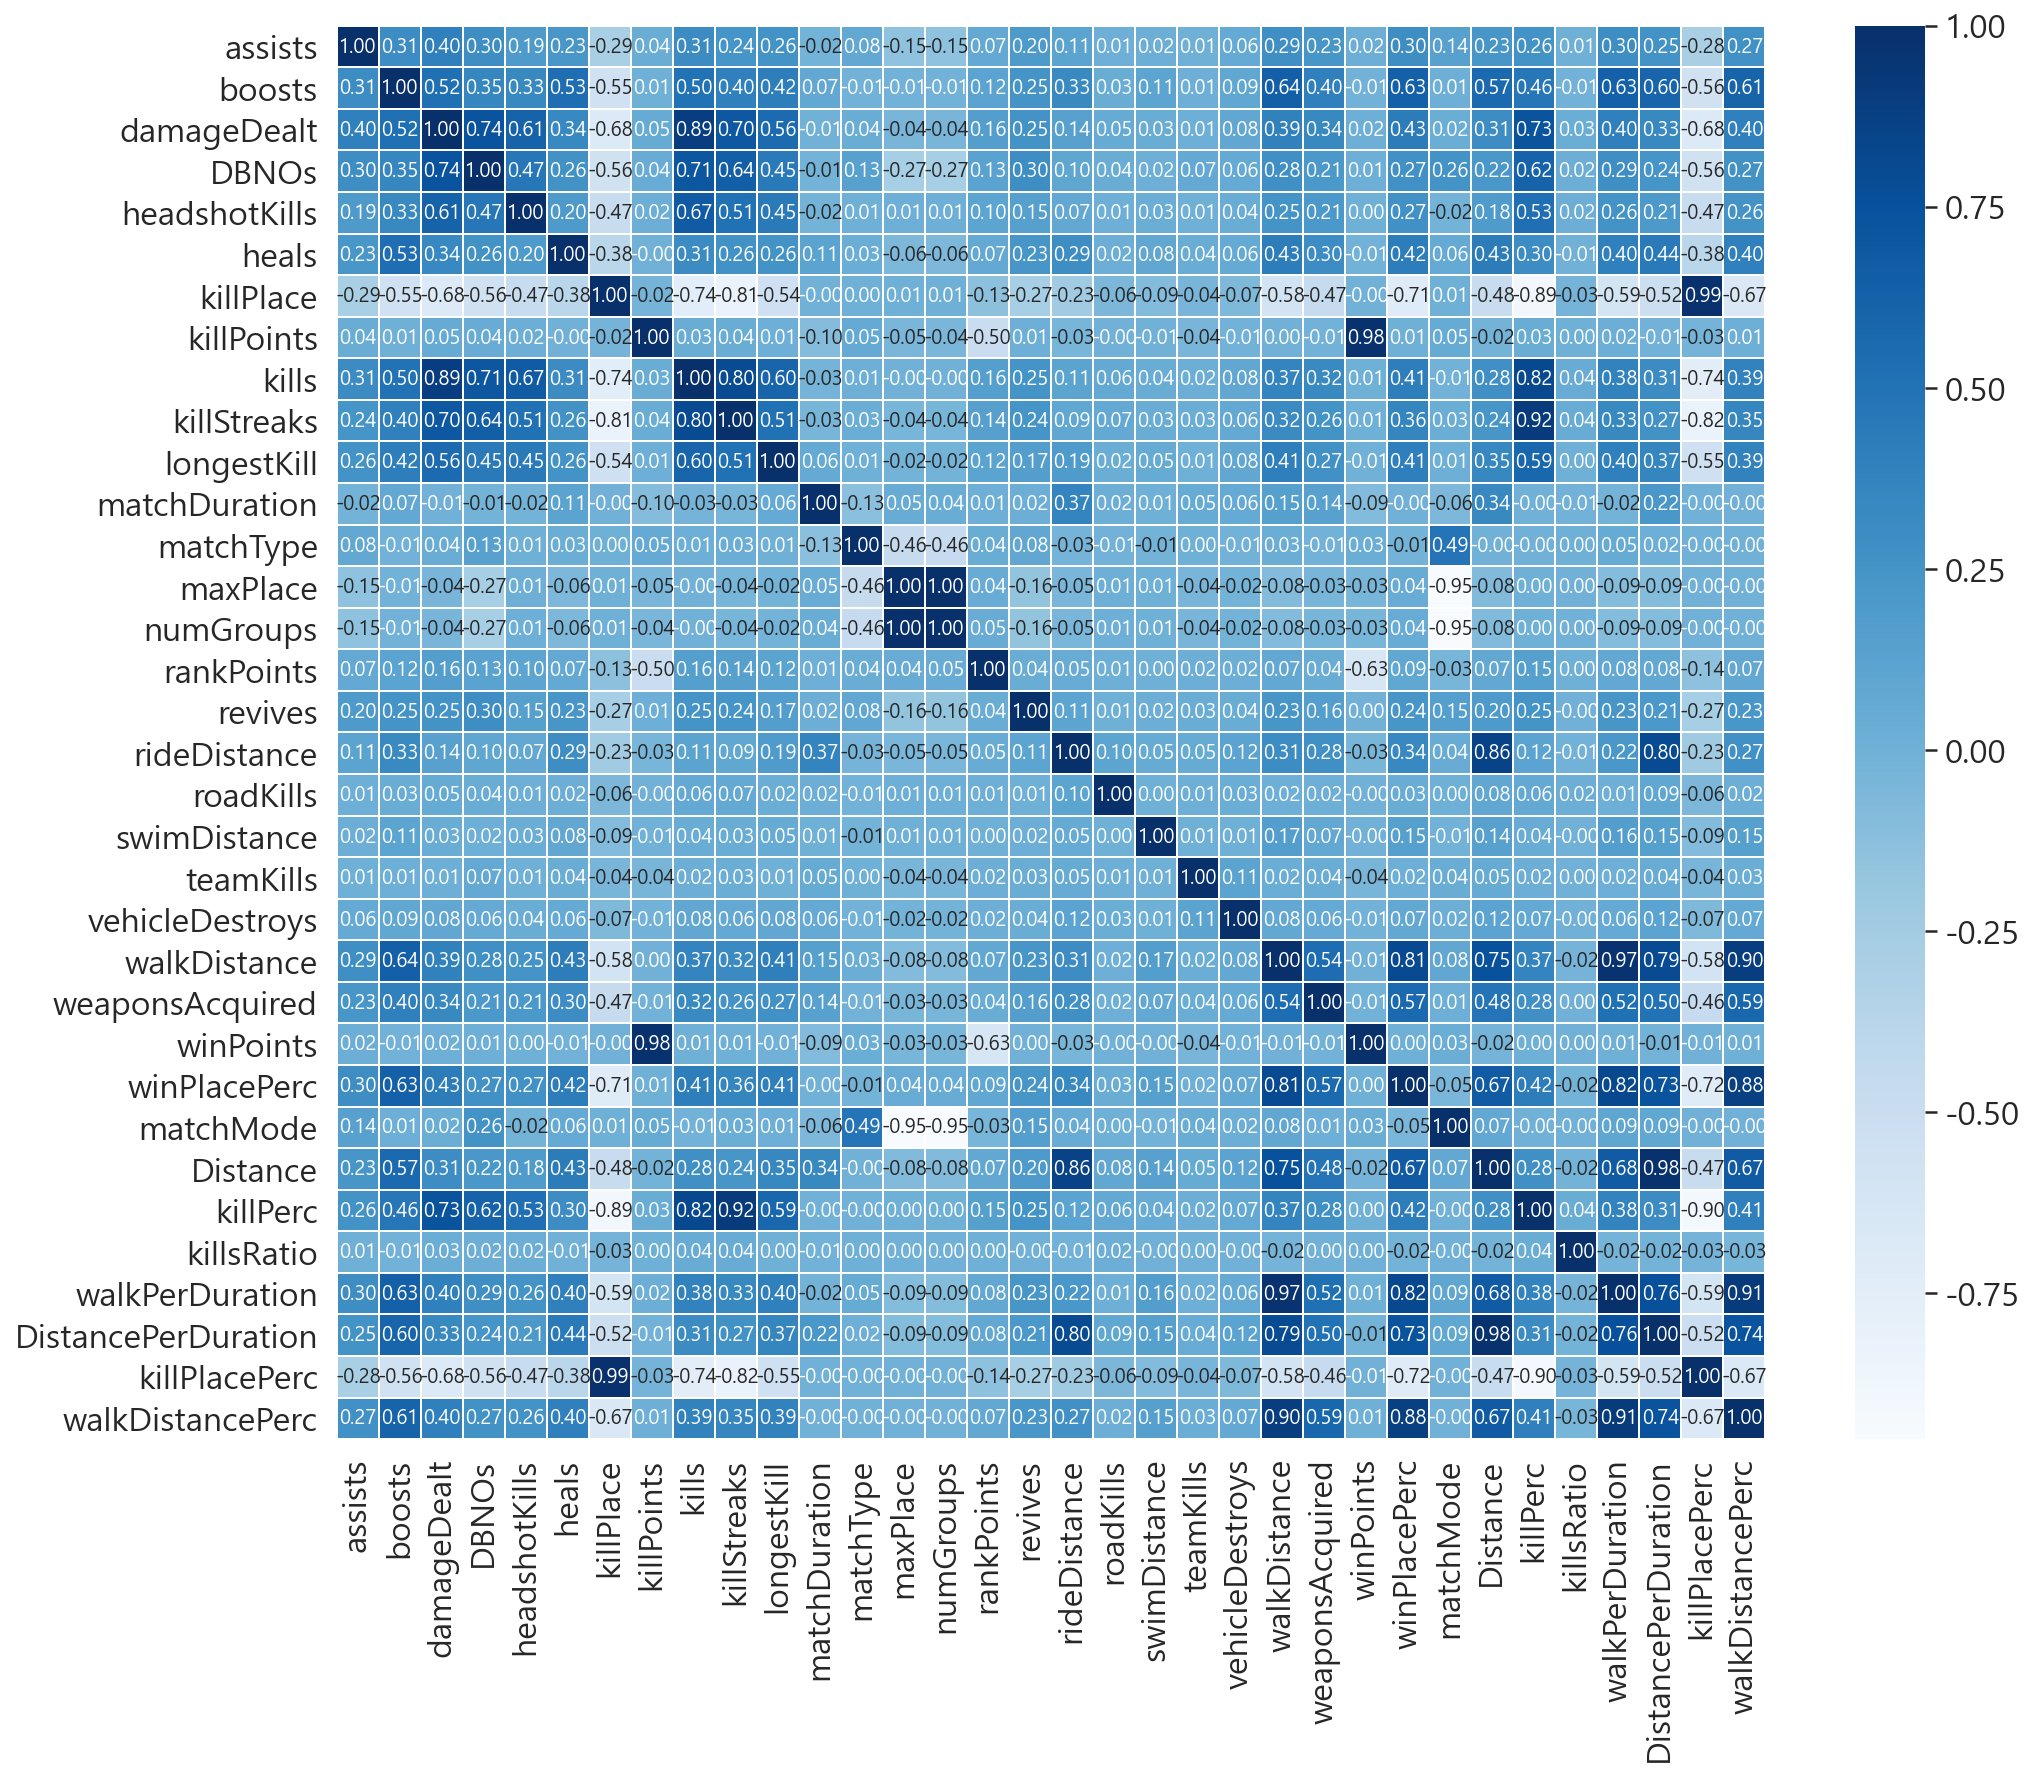

In [20]:
# 상관관계
plt.figure(figsize=(16,13))
sns.heatmap(data = newtrain.corr(), 
            annot=True, fmt = '.2f', linewidths=.5, cmap='Blues', annot_kws={"size": 10})

#### 이상치 대체 + 로그변환
1,99% 이상치 or 3xIQR 이상치 중 이상치 개수가 더 적게 나오는 경우를 택하여 이상치 대체

이상치 대체 후에도 right skewed가 있는 경우 로그 변환

In [25]:
newtrain = replace_outlier2(newtrain, column ='weaponsAcquired')
newtrain = replace_outlier2(newtrain, column ='boosts')
newtrain = replace_outlier2(newtrain, column ='Distance')
newtrain['Distance'] = np.log1p(newtrain['Distance'])
newtrain = replace_outlier(newtrain, column ='heals')
newtrain = replace_outlier(newtrain, column ='assists')
newtrain = replace_outlier(newtrain, column ='kills')
newtrain = replace_outlier(newtrain, column ='damageDealt')
newtrain['damageDealt'] = np.log1p(newtrain['damageDealt'])
newtrain = replace_outlier(newtrain, column ='headshotKills')
newtrain = replace_outlier2(newtrain, column ='killStreaks')
newtrain = replace_outlier3(newtrain, column ='matchDuration')
newtrain = replace_outlier(newtrain, column ='revives')
newtrain = replace_outlier(newtrain, column ='teamKills')
newtrain = replace_outlier(newtrain, column ='DBNOs')
newtrain = replace_outlier(newtrain, column ='longestKill')
newtrain['longestKill'] = np.log1p(newtrain['longestKill'])
newtrain = replace_outlier2(newtrain, column ='rankPoints')
newtrain = maxPlace_outlier2(newtrain)
newtrain = replace_outlier2(newtrain, column ='walkPerDuration')
newtrain['DistancePerDuration'] = np.log1p(newtrain['walkPerDuration'])
newtrain = replace_outlier(newtrain, column ='killsRatio')
newtrain['killsRatio'] = np.log1p(newtrain['killsRatio'])
newtrain = replace_outlier3(newtrain, column ='DistancePerDuration')
newtrain['DistancePerDuration'] = np.log1p(newtrain['DistancePerDuration'])
newtrain = replace_outlier2(newtrain, column ='walkDistance')
newtrain['walkDistance'] = np.log1p(newtrain['walkDistance'])
newtrain = replace_outlier(newtrain, column ='rideDistance')
newtrain['rideDistance'] = np.log1p(newtrain['rideDistance'])
newtrain = replace_outlier(newtrain, column ='swimDistance')
newtrain['swimDistance'] = np.log1p(newtrain['swimDistance'])
print('전처리 완료')

weaponsAcquired outlier 개수 : 6966 

boosts outlier 개수 : 15550 

Distance outlier 개수 : 19325 

heals outlier 개수 : 42993 

assists outlier 개수 : 14400 

kills outlier 개수 : 32985 

damageDealt outlier 개수 : 43453 

headshotKills outlier 개수 : 16633 

killStreaks outlier 개수 : 655 

matchDuration outlier 개수 : 2155 

revives outlier 개수 : 21420 

teamKills outlier 개수 : 8136 

DBNOs outlier 개수 : 31016 

longestKill outlier 개수 : 43413 

rankPoints outlier 개수 : 2721 

maxPlace outlier 개수 : 54950 

walkPerDuration outlier 개수 : 737 

killsRatio outlier 개수 : 43461 

DistancePerDuration outlier 개수 : 0 

walkDistance outlier 개수 : 1554 

rideDistance outlier 개수 : 43450 

swimDistance outlier 개수 : 43420 

전처리 완료


In [29]:
df = train[['walkDistance','damageDealt']]

print('<로그 변환 전 왜도와 첨도>')
for i in list(df.columns):
    print('- '+i)
    print("Skewness: {:.3f}".format(df[i].skew())) 
    print("Kurtosis: {:.3f}".format(df[i].kurt()),'\n')


print('<로그 변환 후 왜도와 첨도>')
df = newtrain[['walkDistance','damageDealt']]

for i in list(df.columns):
    print('- '+i)
    print("Skewness: {:.3f}".format(df[i].skew())) 
    print("Kurtosis: {:.3f}".format(df[i].kurt()),'\n')

<로그 변환 전 왜도와 첨도>
- walkDistance
Skewness: 1.093
Kurtosis: 0.991 

- damageDealt
Skewness: 2.959
Kurtosis: 20.113 

<로그 변환 후 왜도와 첨도>
- walkDistance
Skewness: -0.755
Kurtosis: -0.087 

- damageDealt
Skewness: -0.686
Kurtosis: -1.109 



<AxesSubplot:>

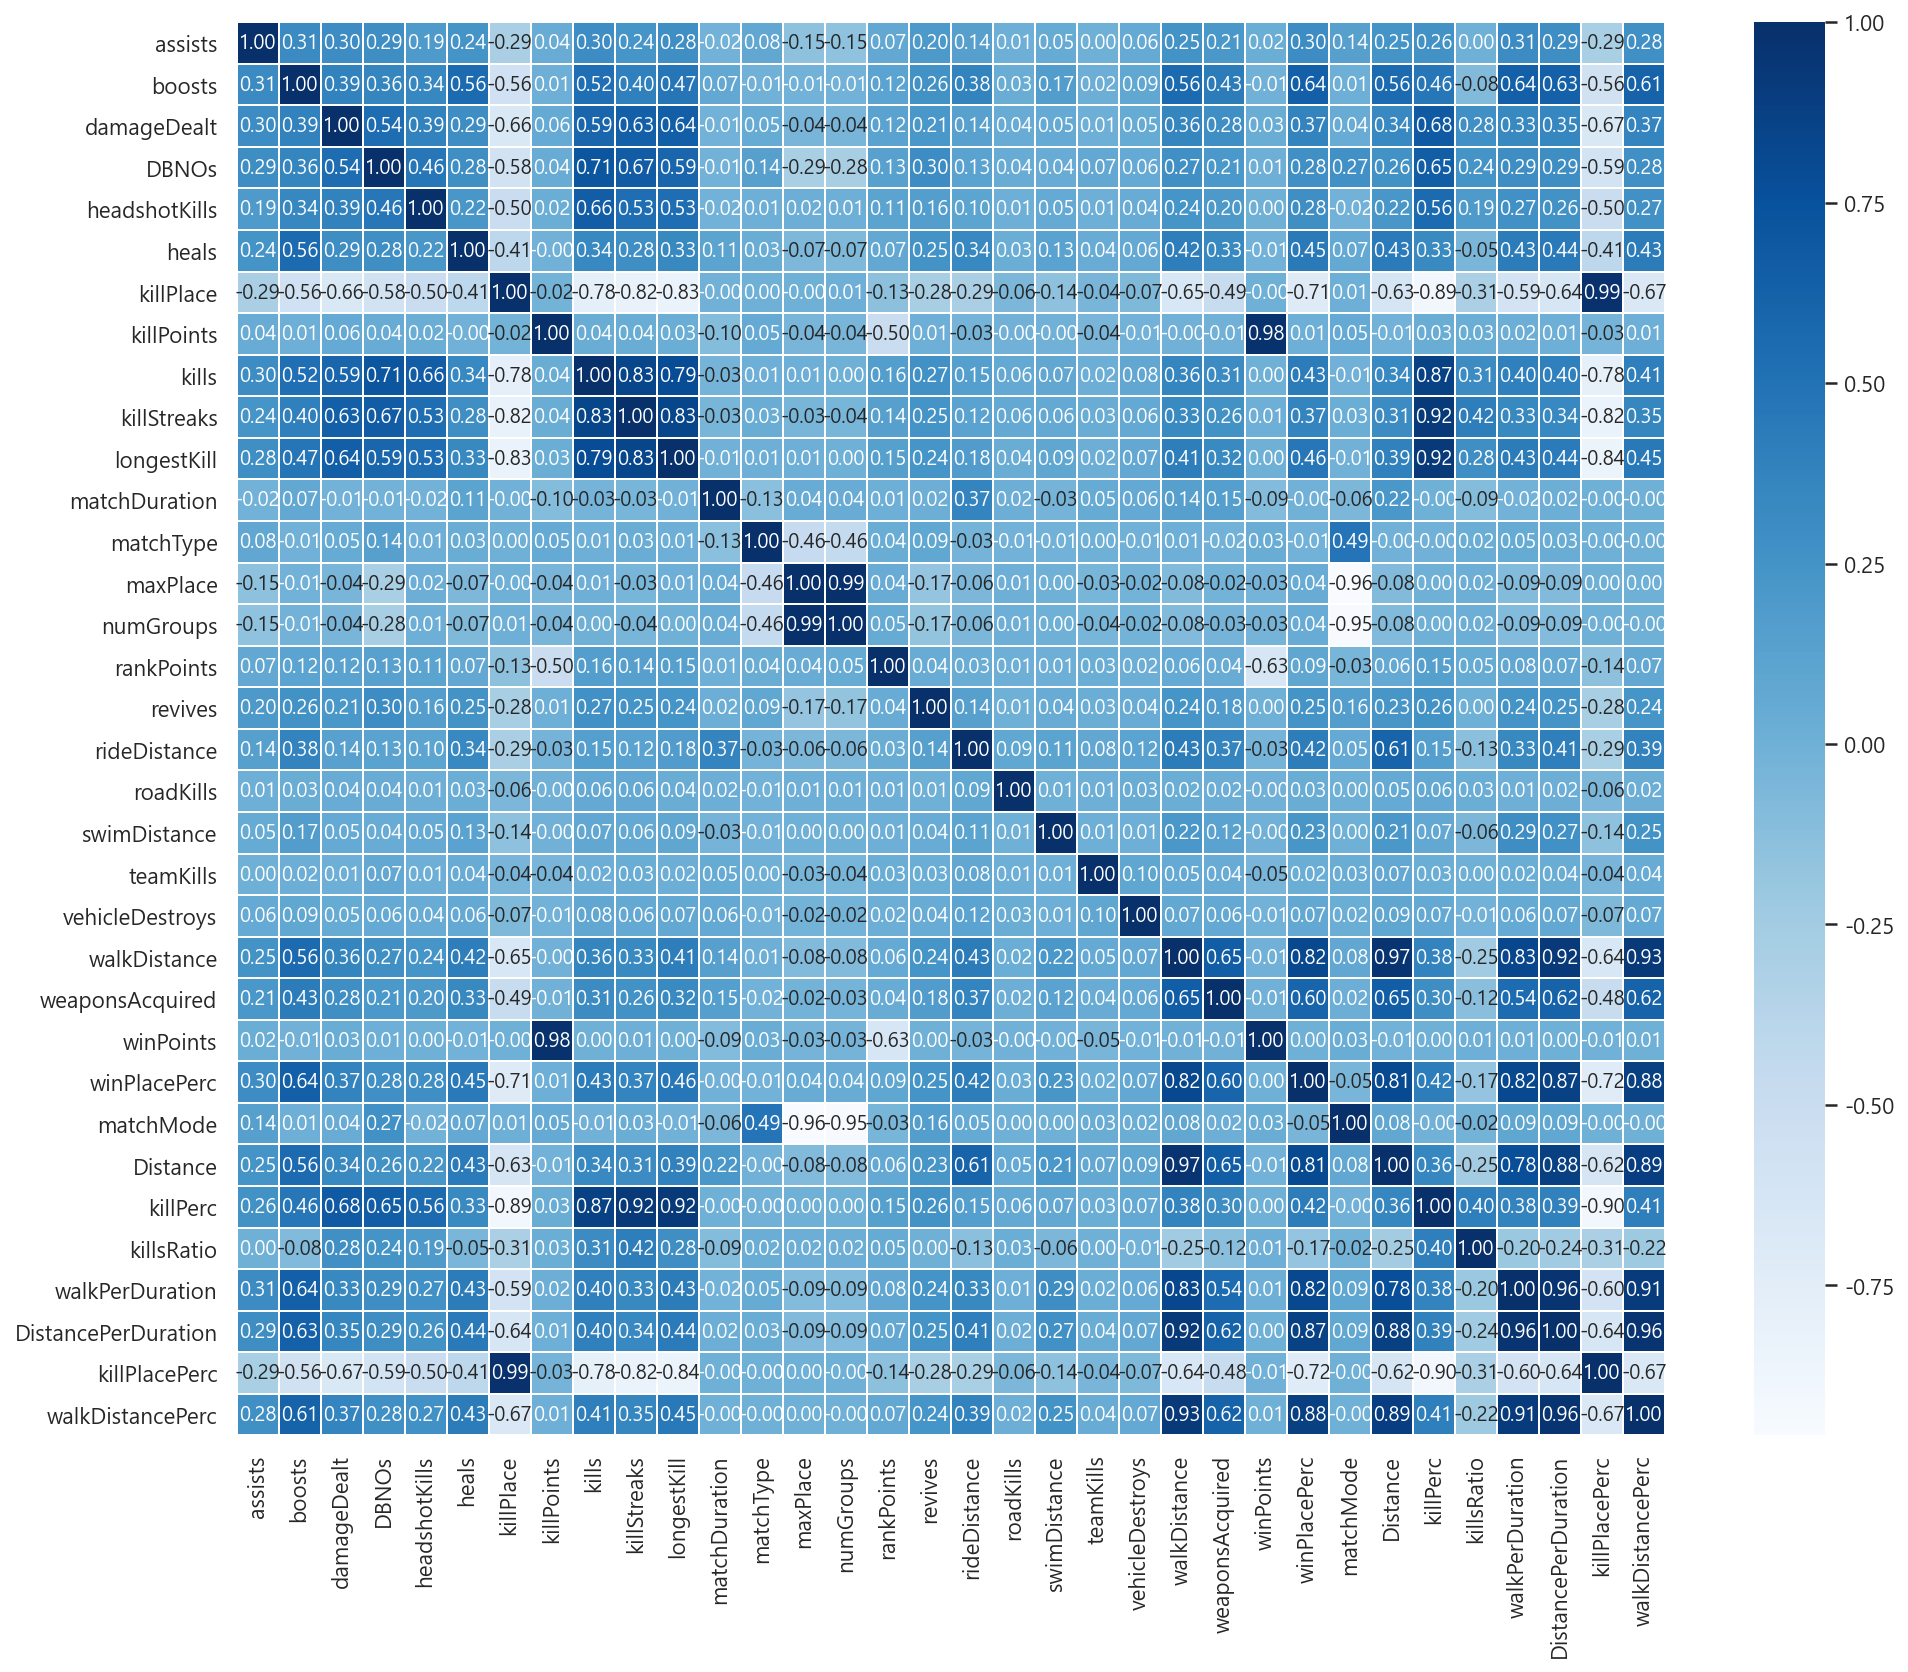

In [15]:
# 상관관계
plt.figure(figsize=(16,13))
sns.heatmap(data = newtrain.corr(), 
            annot=True, fmt = '.2f', linewidths=.5, cmap='Blues', annot_kws={"size": 10})

#### 이상치 대체, 로그 변환 후 분포

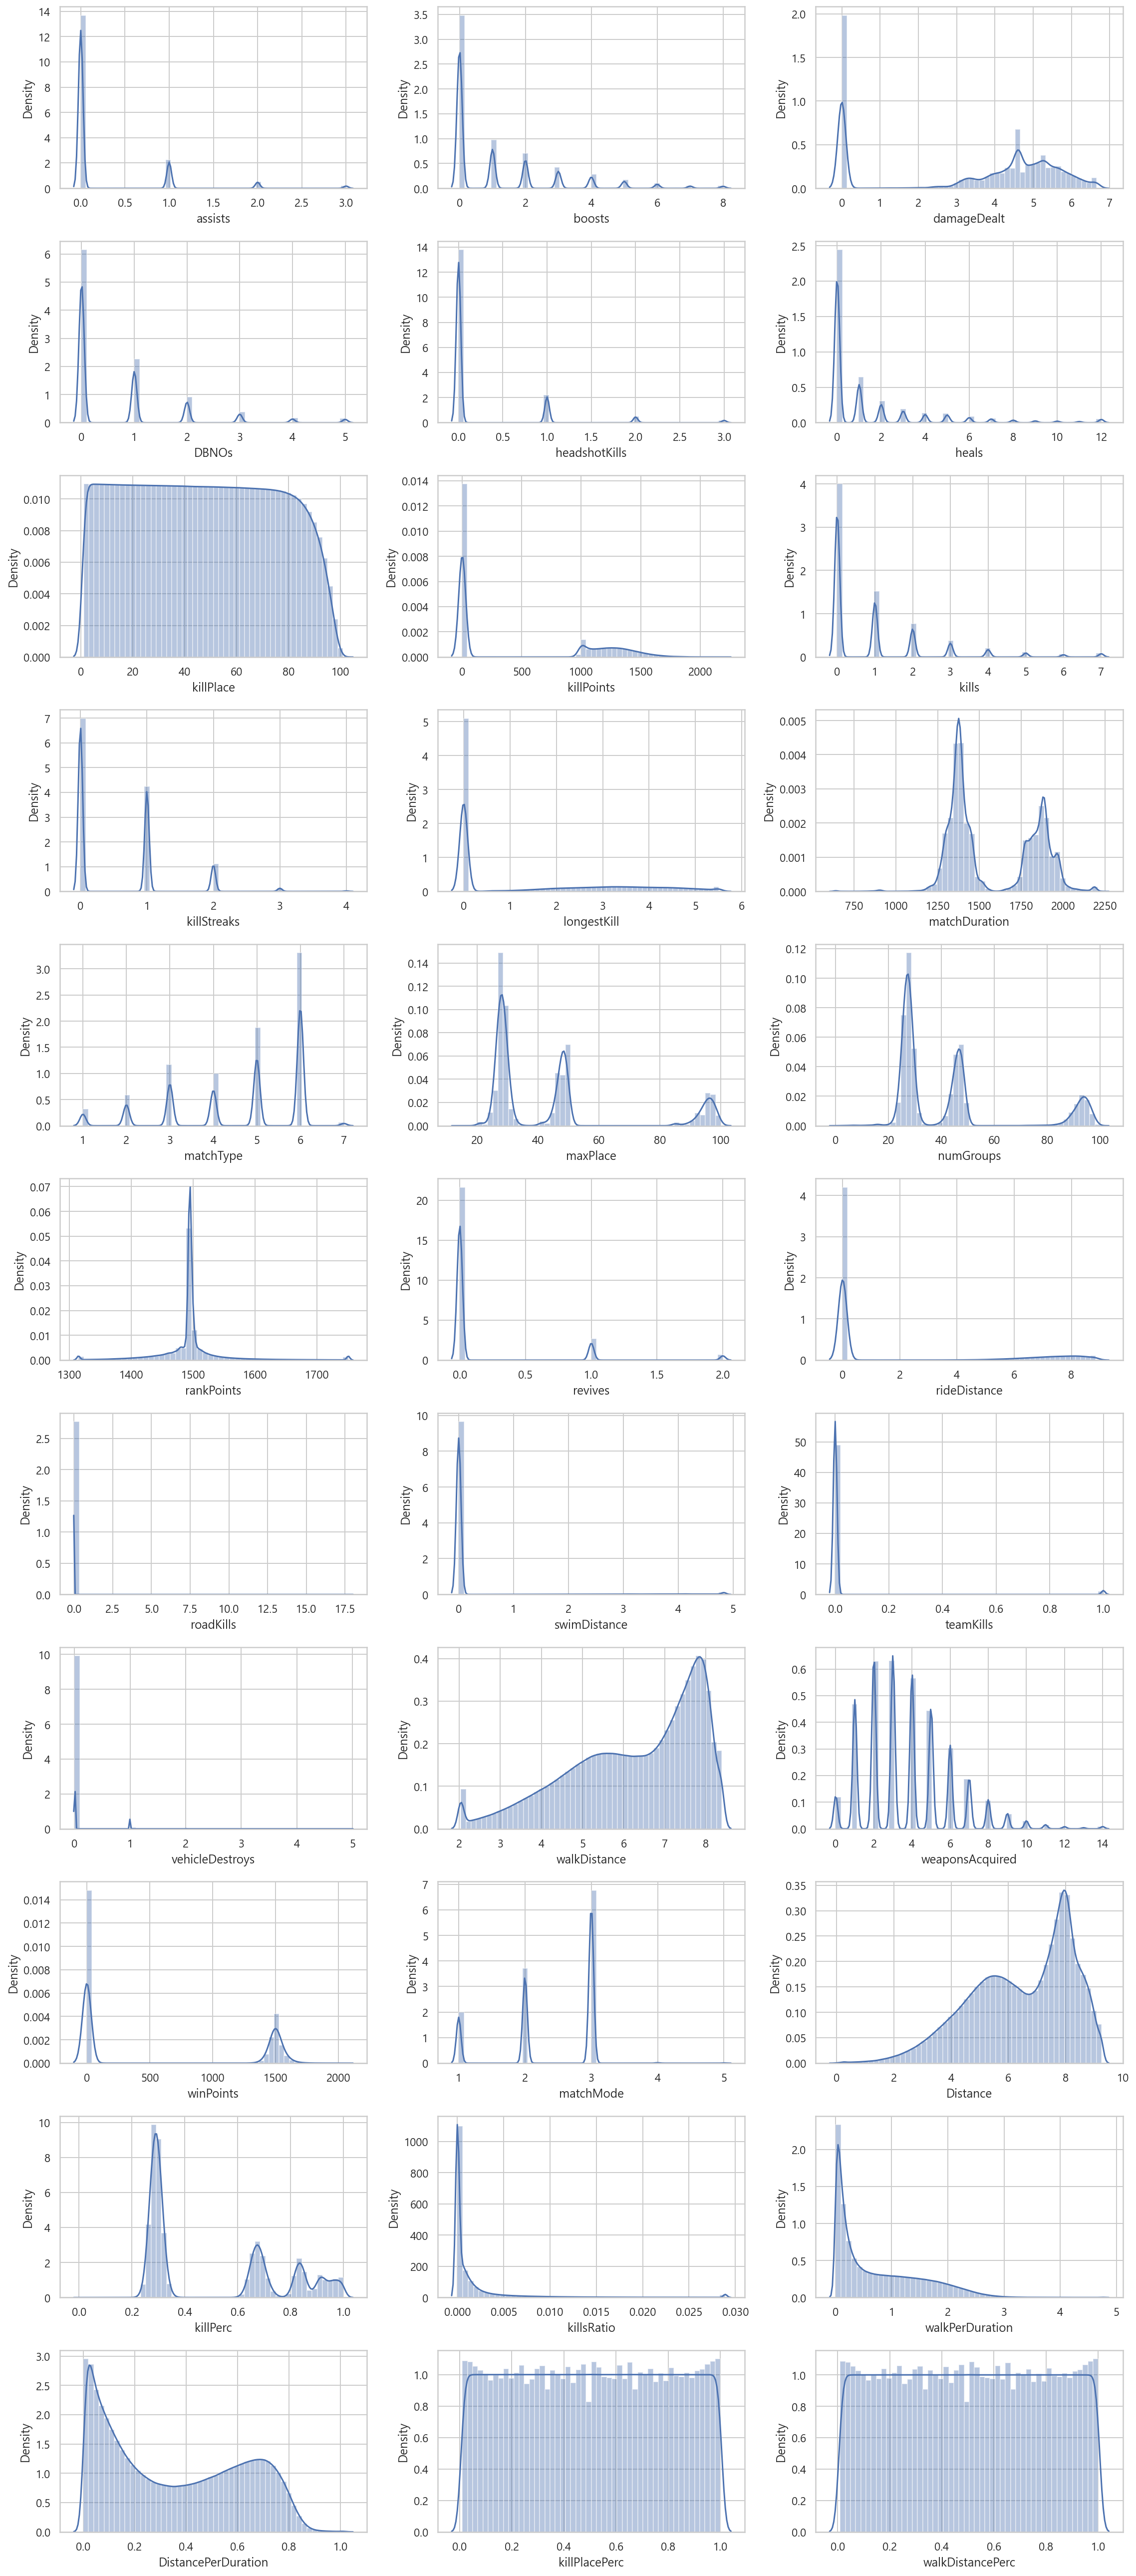

In [41]:
columns = list(newtrain.columns)
columns.remove('winPlacePerc')

plt.figure(figsize=(16,36))
i = 0
for val in columns:
    plt.subplot(11,3,i+1)
    sns.distplot(newtrain[val])
    i += 1    
    
plt.tight_layout()

## 04 순위 예측 모델

In [49]:
df = newtrain.drop(columns=['roadKills','vehicleDestroys','killPoints','winPoints','numGroups'])

start_time = timeit.default_timer() # 시작 시간 체크
x = df.drop(columns = 'winPlacePerc')
y = df['winPlacePerc']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 1000)

#순위 예측이므로 target 변수가 연속형, 따라서 분류가 아닌 회귀 사용
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1)

#모델 fitting
rf.fit(x_train,y_train)

#분류가 아니므로 accuracy_score 사용 X -> random forest 내장 score 사용
print('성능(accuracy) :', rf.score(x_test, y_test)) 

y_pred = rf.predict(x_test)
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_pred))) #MSE
print('mean_absolute_errors: {}'.format(mean_absolute_error(y_test, y_pred)))

terminate_time = timeit.default_timer() # 종료 시간 체크  
spend_time = terminate_time - start_time
print("%i분"%(spend_time//60), "%i초 걸렸습니다." % (spend_time%60))

성능(accuracy) : 0.9520014110758424
mean_squared_errors: 0.0044035341594199804
mean_absolute_errors: 0.04756691703411582
17분 26초 걸렸습니다.


### valid set 생성하여 과적합 확인

In [11]:
df = newtrain.drop(columns=['roadKills','vehicleDestroys','killPoints','winPoints','numGroups'])

start_time = timeit.default_timer() # 시작 시간 체크
x = df.drop(columns = 'winPlacePerc')
y = df['winPlacePerc']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1000)

x_train2, x_valid, y_train2, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1000)


rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rf.fit(x_train2,y_train2)

#과적합 확인
print('성능(accuracy) :', rf.score(x_test, y_test)) 

y_pred = rf.predict(x_test)
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_pred))) #MSE
print('mean_absolute_errors: {}'.format(mean_absolute_error(y_test, y_pred)))

terminate_time = timeit.default_timer() # 종료 시간 체크  
spend_time = terminate_time - start_time
print("%i분"%(spend_time//60), "%i초 걸렸습니다." % (spend_time%60))

성능(accuracy) : 0.951693828239447
mean_squared_errors: 0.004431752729117062
mean_absolute_errors: 0.04770423214157511
13분 47초 걸렸습니다.


## 05 최종 변수중요도

In [ ]:
df = newtrain.drop(columns=['roadKills','vehicleDestroys','killPoints','winPoints','numGroups'])

x = df.drop(columns = 'winPlacePerc')
y = df['winPlacePerc']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1000)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rf.fit(x_train,y_train)

features = list(x.columns)

plt.figure(figsize = (16,12))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 